# Text classification using Transformers.

<p align="center">
  <a href="https://colab.research.google.com/github/auduvignac/llm-finetuning/blob/main/notebooks/project/draft.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Ouvrir dans Google Colab"/>
  </a>
</p>

## Introduction

L’objectif de ce projet est de réaliser le **fine-tuning d’un Large Language Model (LLM)**, en particulier **DistilBERT**, sur un jeu de données de classification de textes.

DistilBERT est une version compressée et optimisée du modèle BERT, développée par Hugging Face.
Il conserve environ **97 % des performances de BERT** tout en étant **40 % plus léger** et **60 % plus rapide** à l’entraînement et à l’inférence.
Ces caractéristiques en font un modèle particulièrement adapté aux projets pédagogiques et aux cas d’usage nécessitant un compromis entre performance et efficacité computationnelle.

Dans ce projet, nous allons :

* Télécharger et préparer un jeu de données textuel pour la classification de sentiments.
* Adapter le tokenizer et le modèle DistilBERT à ce dataset.
* Entraîner et évaluer le modèle en suivant un pipeline de fine-tuning.
* Analyser les performances obtenues (accuracy, F1-score, matrice de confusion, etc.) et discuter des résultats.

Le projet suit les consignes définies dans le cadre du module *LLM Fine-tuning* : il s’agit d’un travail en binôme, rendu sous la forme d’un **notebook Jupyter** intégrant à la fois le **code, les visualisations et les analyses**.

## Contexte

La classification de texte, et en particulier la **classification de sentiments**, est une tâche classique du traitement automatique du langage naturel (NLP).
Elle consiste à prédire si un texte exprime une opinion **positive** ou **négative**, par exemple dans le cadre de critiques de films, de produits ou de services.

Cette tâche est pertinente car :

* Elle met en jeu des enjeux réels de l’industrie (analyse d’opinions clients, veille sur les réseaux sociaux, modération de contenu, etc.).
* Elle sert souvent de **benchmark** pour comparer des modèles de NLP.
* Elle illustre bien le processus de fine-tuning d’un modèle pré-entraîné sur un corpus généraliste vers une tâche spécifique.

Le modèle choisi pour ce projet, **DistilBERT**, est une version compressée du modèle BERT :

* il réduit le nombre de paramètres et accélère les calculs,
* tout en conservant un haut niveau de performance,
* ce qui le rend adapté à un entraînement sur machine locale avec des ressources limitées (GPU de petite capacité par exemple).

Dans ce projet, nous utiliserons un dataset de type **classification binaire** (par exemple *IMDb Reviews*), permettant de mettre en œuvre un pipeline complet :

* **Préparation des données** (tokenisation, séparation train/validation)
* **Fine-tuning** du modèle DistilBERT
* **Évaluation et analyse des performances**

## Préparation de l’environnement

Dans cette section, l’ensemble des bibliothèques nécessaires au projet sont importées.
Elles couvrent plusieurs volets :

* **Gestion et exploration de données**

  * `datasets` (Hugging Face) : chargement, manipulation et structuration de jeux de données (`DatasetDict`, `load_dataset`, `Value`)
  * `numpy`, `pandas` : calcul numérique et manipulation de tableaux / dataframes
  * `random`, `math`, `json` : utilitaires standards de Python
  * `tabulate` : affichage formaté de tableaux

* **PyTorch (apprentissage profond)**

  * `torch`, `torch.nn`, `torch.nn.functional` : définition et manipulation de réseaux de neurones
  * `torch.optim` : optimisateurs (AdamW, etc.)
  * `clip_grad_norm_` : contrôle de la norme des gradients pour éviter l’explosion
  * `DataLoader` : création de batchs pour l’entraînement et l’évaluation

* **Transformers (Hugging Face)**

  * `DistilBertTokenizer`, `DistilBertForSequenceClassification`, `DistilBertConfig`
  * `AutoTokenizer`, `AutoModelForSequenceClassification` : versions génériques
  * `get_linear_schedule_with_warmup` : scheduler d’apprentissage avec phase de *warmup*

* **Évaluation des performances** (scikit-learn)

  * `accuracy_score`, `f1_score`, `precision_recall_fscore_support`,
  * `confusion_matrix`, `classification_report`,
  * `log_loss`, `brier_score_loss`

* **Visualisation**

  * `matplotlib.pyplot` : graphiques et visualisation des courbes
  * Options Jupyter : `%matplotlib inline` pour affichage intégré, et `InlineBackend` configuré en SVG pour une meilleure qualité

* **Suivi de l’entraînement**

  * `tqdm`, `tqdm.notebook` : barres de progression pour suivre les boucles (entraînement, évaluation, prétraitement)

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import json
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import (
    DatasetDict,
    Value,
    load_dataset,
)
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_recall_fscore_support,
)
from tabulate import tabulate
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm.notebook import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    get_linear_schedule_with_warmup,
)

## Préparation du dispositif et reproductibilité

* La reproductibilité est assurée en fixant une **graine aléatoire** (`seed`) : avec la même graine, le mélange des données, l’initialisation des poids et d’autres opérations stochastiques donnent les mêmes résultats d’un exécutable à l’autre.
* Le dispositif de calcul est configuré de manière à utiliser le **GPU** si disponible, ou à défaut le **CPU**.
* L’instruction d’affichage permet de confirmer le dispositif effectivement sélectionné.

In [2]:
# Reproductibilité
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


Après la préparation de l’environnement et la mise en place des conditions de reproductibilité, l’étape suivante consiste à définir une **classe `LLMFineTuner`** qui regroupe et automatise l’ensemble du *workflow* de *fine-tuning*.
Cette classe repose sur une composante utilitaire, la **classe `DataCollator`**, qui simplifie la préparation des batchs et contribue à la généralisation du modèle en gérant efficacement la construction des entrées.

## Définition des classes `LLMFineTuner` et `DataCollator`



### Classe `DataCollator`

La classe `DataCollator` est une composante utilitaire qui s'occupe de la préparation des batchs de données.
Elle a pour rôle de :

- gérer la **tokenisation et le padding dynamique** des séquences,
- regrouper les exemples sous forme de batchs compatibles avec PyTorch,
- fournir un format uniforme des entrées pour l'entraînement et l'évaluation du modèle.

Cette classe permet d'isoler la logique de prétraitement des données afin d'alléger l'implémentation du pipeline principal.

In [43]:
class DataCollator:
    """
    Regroupe et organise les exemples en batchs pour le fine-tuning.

    Cette classe :
    - applique un padding dynamique des séquences en fonction du batch,
    - prépare les tenseurs nécessaires (input_ids, attention_mask, labels),
    - retourne un dictionnaire prêt à être passé au modèle Hugging Face.
    """

    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(
        self, batch, max_length=256, padding="longest", return_tensors="pt"
    ) -> dict[str, torch.Tensor]:
        """
        Prépare un batch de données pour le modèle.

        Applique un padding dynamique via `tokenizer.pad` et retourne
        les tenseurs nécessaires : input_ids, attention_mask et labels.
        """
        return self.tokenizer.pad(
            batch,
            padding=padding,
            max_length=max_length,
            return_tensors=return_tensors,
        )

In [44]:
class TemperatureScaler(nn.Module):
    """
    Module de calibration par Temperature Scaling.
    """
    def __init__(self):
        super().__init__()
        self.T = nn.Parameter(torch.ones(1))  # initialisé à 1.0

    def forward(self, logits):
        return logits / self.T.clamp(min=1e-6)

### Classe `LLMFineTuner`

La classe `LLMFineTuner` implémente l’ensemble du **pipeline de fine-tuning** pour un modèle DistilBERT appliqué à la classification de textes.
Elle centralise toutes les étapes :

* chargement et préparation du dataset,
* initialisation du tokenizer, du modèle et du data collator,
* configuration de l’optimiseur et du scheduler,
* entraînement, validation et évaluation du modèle,
* inférence sur de nouveaux exemples.

Grâce à cette classe, le workflow est rendu **plus modulaire, lisible et réutilisable**, facilitant les expérimentations et la reproductibilité.

## Méthodes de la classe `LLMFineTuner`

| Étape | Méthode | Rôle |
|-------|---------|------|
| **1. Initialisation** | `__init__` | Prépare les attributs (dataset, modèle, device, loaders, tokenizer). |
| **2. Dataset & Tokenizer** | `set_dataset` | Charge, nettoie et normalise le dataset (labels 0/1). |
| | `set_tokenizer` | Initialise le tokenizer depuis un modèle pré-entraîné. |
| **3. Pré-processing** | `split_dataset` | Mélange, sous-échantillonne, tokenize et crée splits train/validation. |
| | `set_data_collator` | Définit le collator pour gérer le padding dynamique. |
| | `set_loaders` | Crée les DataLoader train/validation. |
| | `make_loader_for_tokenizer` | Fabrique un DataLoader adapté à un split externe (utile pour zero-shot). |
| **4. Modèle** | `set_model` | Charge le modèle pré-entraîné et l’adapte au device (CPU/GPU). |
| **5. Optimisation** | `set_optimizer` | Initialise AdamW avec LR et weight decay. |
| | `set_scheduler` | Définit le scheduler linéaire avec warmup. |
| | `set_optimizer_and_scheduler` | Configure optimizer + scheduler ensemble. |
| **6. Entraînement & Évaluation** | `train_and_validate` | Boucle d’entraînement + validation avec sauvegarde du meilleur modèle. |
| | `evaluate` | Calcule accuracy, F1, confusion matrix, classification report. |
| | `count_parameters` | Retourne (total, trainable) paramètres du modèle. |
| | `plot_history` | Affiche les courbes loss/accuracy. |
| **7. Inférence** | `predict_sentiment` | Prédit le sentiment d’un texte unique. |
| | `predict_batch` | Prédit les sentiments pour une liste de textes. |
| **8. Orchestrateur** | `workflow` | Exécute automatiquement la séquence selon le mode (`train`, `evaluation`, `inference`). |
| **9. Evaluation par ajustement de seuil** | `collect_probs_labels` | Récupère les probabilités et labels. |
| | `tune_threshold_macro_f1` | Cherche le seuil optimal pour le F1-macro. |
| | `eval_at_threshold` | Calcule accuracy, F1, confusion matrix et métriques par classe à un seuil donné. |
| **Supplément** | `zero_shot_evaluate` | Évalue un modèle fine-tuné sur un dataset externe (sans ré-entraînement). |

In [45]:
class LLMFineTuner:
    """
    Pipeline de fine-tuning pour la classification de sentiments avec des
    modèles Transformers (ex. DistilBERT, RoBERTa).

    Étapes du pipeline :
    1. Initialisation
        - __init__ : constructeur de la classe

    2. Jeu de données & Tokenizer
        - set_dataset : charge et normalise le dataset (labels 0/1)
        - set_tokenizer : initialise le tokenizer pré-entraîné

    3. Pré-traitement
        - split_dataset : mélange, sous-échantillonne, tokenize et crée les splits train/validation
        - set_data_collator : définit le collator pour le padding dynamique
        - set_loaders : crée les DataLoader train/validation
        - make_loader_for_tokenizer : crée un DataLoader adapté à un split externe (utile pour le zero-shot)

    4. Modèle
        - set_model : charge le modèle pré-entraîné et l'envoie sur le device (CPU/GPU)

    5. Optimisation
        - set_optimizer : définit l'optimiseur AdamW
        - set_scheduler : planifie le scheduler linéaire avec warmup
        - set_optimizer_and_scheduler : configuration de l'optimizer et du
            scheduler

    6. Entraînement & Évaluation
        - train_and_validate : boucle d'entraînement et validation, sauvegarde
            du meilleur modèle
        - evaluate : calcule les métriques (accuracy, F1, matrice de confusion,
            rapport de classification)
        - count_parameters : retourne le nombre de paramètres (total,
            entraînables)
        - plot_history : affiche les courbes de loss et d'accuracy

    7. Inférence
        - predict_sentiment : prédit le sentiment d'un texte unique
        - predict_batch : prédit les sentiments pour une liste de textes

    8. Orchestrateur du workflow
        - workflow : exécute automatiquement la séquence complète selon le mode
          ("train", "evaluation", "inference")

    9. Évaluation par seuil
        - collect_probs_labels : collecte probabilités et labels
        - tune_threshold_macro_f1 : cherche le seuil optimal maximisant le
            F1-macro
        - eval_at_threshold : calcule accuracy, F1, matrice de confusion et
            métriques par classe à un seuil donné

    10. Évaluation Zero-shot
        - zero_shot_evaluate : évalue un modèle fine-tuné sur un dataset
            externe sans ré-entraînement
    """

    # =========================
    # 1. INITIALISATION
    # =========================

    def __init__(
        self,
        dataset="scikit-learn/imdb",
        model_cls=DistilBertForSequenceClassification,
        num_labels=2,  # "negative" (0) et "positive" (1)
        pretrained_model_name_or_path="distilbert-base-uncased",
        tokenizer_cls=DistilBertTokenizer,
    ):
        """
        Initialise la classe LLMFineTuner et prépare l'environnement de
        travail.

        Cette méthode définit les attributs essentiels pour le fine-tuning :
        - le jeu de données (nom ou objet Hugging Face),
        - les classes nécessaires au modèle et au tokenizer,
        - le nombre de labels (par défaut 2 pour une classification binaire),
        - le chemin ou nom du modèle pré-entraîné,
        - le device d'exécution (GPU si disponible, sinon CPU).

        Args:
            dataset (str ou Dataset, optionnel) :
                Nom du dataset Hugging Face (ex. "scikit-learn/imdb") ou dataset
                  déjà chargé.
            model_cls (nn.Module, optionnel) :
                Classe du modèle de classification à utiliser (par défaut
                  DistilBERT).
            num_labels (int, optionnel) :
                Nombre de classes de sortie du modèle (par défaut 2 : "negative"
                  et "positive").
            pretrained_model_name_or_path (str, optionnel) :
                Nom ou chemin vers le modèle pré-entraîné à charger.
            tokenizer_cls (transformers.PreTrainedTokenizer, optionnel) :
                Classe du tokenizer associée au modèle (par défaut DistilBERT
                  tokenizer).

        Attributs principaux initialisés :
            - self.dataset : référence vers le dataset choisi
            - self.train_set / self.valid_set : splits entraînement et validation
                (None par défaut)
            - self.data_collator, self.train_loader, self.valid_loader : objets
                DataLoader (None par défaut)
            - self.tokenizer_cls, self.model_cls : classes pour instancier le
                tokenizer et le modèle
            - self.num_labels, self.pretrained_model_name_or_path : configuration
                du modèle
            - self.device : "cuda" si GPU disponible, sinon "cpu"
        """
        # Données
        self.dataset = dataset
        self.train_set = None
        self.valid_set = None

        # DataLoader
        self.data_collator = None
        self.train_loader = None
        self.valid_loader = None

        # Modèle et tokenisation
        self.tokenizer_cls = tokenizer_cls
        self.model_cls = model_cls
        self.num_labels = num_labels
        self.pretrained_model_name_or_path = pretrained_model_name_or_path

        # Environnement
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

    # =========================
    # 2. JEU DE DONNEES & TOKENIZER
    # =========================
    def set_dataset(self, verbose=False) -> None:
        """
        Charge et prépare le jeu de données pour l'entraînement et
        l'évaluation.

        Cette méthode :
          - charge le dataset défini dans l'attribut `self.dataset`,
          - renomme les colonnes principales pour garantir la cohérence
            ("review" pour le texte et "sentiment" pour les labels),
          - normalise les labels en entiers 0 (négatif) et 1 (positif),
          - s'assure que la colonne "sentiment" est bien de type `int64`.

        Le traitement s'adapte automatiquement selon le format du dataset :
          - si les labels sont des chaînes de caractères (ex. IMDB : "negative"/"positive"),
            ils sont convertis en entiers,
          - si les labels sont déjà numériques (ex. RottenTomatoes), seul le cast est appliqué.

        Args:
            verbose (bool, optionnel) :
                Si True, affiche un résumé du dataset chargé et normalisé,
                incluant sa taille et sa structure.

        Effets de bord :
            - Met à jour l'attribut `self.dataset` avec un objet DatasetDict
              compatible avec les étapes suivantes du pipeline.
        """
        self.dataset = load_dataset(self.dataset)

        # Récupération des colonnes
        cols = self.dataset["train"].column_names

        # Uniformisation des colonnes
        if "review" not in cols:
            self.dataset = self.dataset.rename_column(cols[0], "review")
        if "sentiment" not in cols:
            self.dataset = self.dataset.rename_column(cols[1], "sentiment")

        # Normaliser les labels en entiers 0/1
        example_val = self.dataset["train"][0]["sentiment"]

        if isinstance(example_val, str):  # IMDB

            def map_labels(example):
                example["sentiment"] = (
                    0 if example["sentiment"].lower() == "negative" else 1
                )
                return example

            # on caste en int après mapping
            self.dataset = self.dataset.map(map_labels).cast_column(
                "sentiment", Value("int64")
            )

        elif isinstance(
            example_val, int
        ):  # RottenTomatoes (cf. dernière cellule du notebook)
            self.dataset = self.dataset.cast_column(
                "sentiment", Value("int64")
            )

        if verbose:
            print(
                f"Dataset loaded and normalized :\n"
                f"{self.dataset}\n"
                f"with {len(self.dataset['train'])} training examples."
            )

    def set_tokenizer(
        self,
        do_lower_case=True,
        verbose=False,
    ) -> None:
        """
        Initialise et charge le tokenizer associé au modèle pré-entraîné.

        Le tokenizer est un élément essentiel du pipeline : il convertit
        le texte brut en tokens numériques exploitables par le modèle.
        Cette méthode utilise la classe de tokenizer définie lors de
        l'initialisation (`self.tokenizer_cls`).

        Args:
            do_lower_case (bool, optionnel) :
                Si True, convertit tout le texte en minuscules
                (utile pour les modèles non sensibles à la casse).
                Valeur par défaut : True.
            verbose (bool, optionnel) :
                Si True, affiche un message confirmant le tokenizer chargé
                et sa provenance.

        Effets de bord :
            - Crée et assigne un objet `self.tokenizer` prêt à être utilisé
              pour l'encodage des textes.
        """
        self.tokenizer = self.tokenizer_cls.from_pretrained(
            self.pretrained_model_name_or_path, do_lower_case=do_lower_case
        )
        if verbose:
            print(
                f"Tokenizer {self.tokenizer_cls.__name__} loaded from "
                f"{self.pretrained_model_name_or_path}"
            )

    # =========================
    # 3. PRE-PROCESSING
    # =========================
    def split_dataset(
        self, max_length=256, n_samples=2000, seed=42, test_size=0.2
    ) -> None:
        """
        Prépare le dataset pour l'entraînement et la validation.

        Cette méthode applique plusieurs étapes :
          1. Mélange aléatoirement le jeu de données d'entraînement initial.
          2. Sélectionne un sous-échantillon de `n_samples` exemples.
          3. Tokenize chaque texte ("review") en séquences d'IDs numériques
            via le tokenizer de l'instance.
          4. Ne conserve que les colonnes essentielles ("input_ids", "labels").
          5. Sépare le dataset en deux splits : entraînement et validation.

        Args:
            max_length (int, optionnel) :
                Longueur maximale des séquences tokenisées.
                Les textes plus longs sont tronqués. (défaut : 256)
            n_samples (int, optionnel) :
                Nombre d'exemples à conserver pour l'entraînement/validation
                afin de réduire le temps de calcul. (défaut : 2000)
            seed (int, optionnel) :
                Graine aléatoire pour assurer la reproductibilité du mélange.
                  (défaut : 42)
            test_size (float, optionnel) :
                Proportion du dataset réservée à la validation (entre 0 et 1).
                  (défaut : 0.2)

        Effets de bord :
            - Met à jour les attributs :
                * `self.train_set` : split d'entraînement
                * `self.valid_set` : split de validation
        """

        def preprocessing_fn(x, tokenizer, max_length=256) -> dict:
            """
            Fonction de prétraitement appliquée à chaque exemple du dataset.

            Cette fonction :
              - récupère le texte de la colonne "review",
              - encode le texte avec le tokenizer fourni afin de générer
                une séquence d'identifiants numériques (`input_ids`),
              - applique une troncature si la séquence dépasse `max_length`,
              - ajoute l'étiquette associée ("sentiment") sous la clé "labels".

            Args:
                x (dict) :
                    Exemple individuel du dataset contenant au minimum les clés
                    "review" (texte) et "sentiment" (label).
                tokenizer (transformers.PreTrainedTokenizer) :
                    Tokenizer utilisé pour convertir le texte en identifiants
                      numériques.
                max_length (int, optionnel) :
                    Longueur maximale autorisée pour les séquences tokenisées.
                    Par défaut 256.

            Returns:
                dict :
                    Exemple enrichi contenant deux nouvelles clés :
                      - "input_ids" : liste des identifiants de tokens
                      - "labels" : valeur entière du sentiment associé
            """
            text = x["review"]
            label = x["sentiment"]

            # Tokenisation
            x["input_ids"] = tokenizer.encode(
                text,
                add_special_tokens=True,
                truncation=True,
                max_length=max_length,
                padding=False,
                return_attention_mask=False,
            )
            x["labels"] = label
            return x

        # Mélanger et sous-échantillonner
        dataset = self.dataset["train"].shuffle(seed).select(range(n_samples))

        # Appliquer le prétraitement
        dataset = dataset.map(
            preprocessing_fn, fn_kwargs={"tokenizer": self.tokenizer}
        )

        # Garder uniquement les colonnes utiles
        dataset = dataset.select_columns(["input_ids", "labels"])

        # Split train / validation
        splitted = dataset.train_test_split(test_size=test_size)

        self.train_set = splitted["train"]
        self.valid_set = splitted["test"]

    def set_data_collator(self) -> None:
        """
        Initialisation du data collator pour la préparation des batchs.

        Le data collator est permet de :
          - regrouper les exemples d'un batch,
          - appliquer un padding dynamique pour que toutes les séquences aient
              la même longueur,
          - retourner les tenseurs prêts à être utilisés par le modèle.

        Effets de bord :
            - Crée et assigne un objet `self.data_collator` basé sur le
              tokenizer de l'instance.
        """
        self.data_collator = DataCollator(self.tokenizer)

    def set_loaders(self, train_batch_size=4, eval_batch_size=4) -> None:
        """
        Crée les DataLoader pour l'entraînement et la validation.

        Cette méthode :
          - vérifie que le data collator a été défini,
          - vérifie que les splits d'entraînement et de validation existent,
          - instancie deux DataLoader PyTorch :
              * `self.train_loader` : pour l'entraînement, avec mélange des exemples,
              * `self.valid_loader` : pour la validation, sans mélange,
          - enregistre également la taille de chaque split (`self.n_train`, `self.n_valid`).

        Args:
            train_batch_size (int, optionnel) :
                Taille de batch pour l'entraînement. (défaut : 4)
            eval_batch_size (int, optionnel) :
                Taille de batch pour la validation. (défaut : 4)

        Raises:
            ValueError :
                - si le data collator n'a pas encore été défini,
                - si le dataset n'a pas encore été découpé en splits
                  d'entraînement et de validation.

        Effets de bord :
            - Met à jour les attributs :
                * `self.train_loader` : DataLoader pour l'entraînement,
                * `self.valid_loader` : DataLoader pour la validation,
                * `self.n_train` : nombre d'exemples d'entraînement,
                * `self.n_valid` : nombre d'exemples de validation.
        """
        if not self.data_collator:
            raise ValueError("Data collator must be set before data loaders.")
        if not self.train_set or not self.valid_set:
            raise ValueError("Dataset must be split before data loaders.")
        self.train_loader = DataLoader(
            batch_size=train_batch_size,
            collate_fn=self.data_collator,
            dataset=self.train_set,
            shuffle=True,
        )
        self.valid_loader = DataLoader(
            batch_size=eval_batch_size,
            collate_fn=self.data_collator,
            dataset=self.valid_set,
            shuffle=False,
        )
        self.n_valid = len(self.valid_set)
        self.n_train = len(self.train_set)

    def make_loader_for_tokenizer(
        self, split, max_len=256, batch_size=8, shuffle=False
    ):
        """
        Crée un DataLoader PyTorch à partir d'un split de dataset Hugging Face
        en utilisant le tokenizer de l'instance.

        Cette méthode est particulièrement utile pour évaluer un modèle déjà
        fine-tuné sur un jeu de données externe (ex. évaluation *zero-shot*).

        Étapes principales :
          1. Encodage des exemples avec le tokenizer.
          2. Suppression des colonnes d'origine pour ne garder que les données
              encodées.
          3. Définition d'une fonction de `collate_fn` qui applique un padding
              dynamique.
          4. Création d'un DataLoader prêt à l'emploi.

        Args:
            split (Dataset) :
                Split Hugging Face à transformer (ex. `dataset["validation"]`).
            max_len (int, optionnel) :
                Longueur maximale des séquences tokenisées. (défaut : 256)
            batch_size (int, optionnel) :
                Taille des batchs générés par le DataLoader. (défaut : 8)
            shuffle (bool, optionnel) :
                Si True, mélange les exemples avant la création des batchs. (défaut : False)

        Returns:
            DataLoader :
                DataLoader PyTorch prêt pour l'entraînement ou l'évaluation,
                avec padding dynamique et labels intégrés.
        """

        def encode(batch):
            out = self.tokenizer(
                batch["text"],
                truncation=True,
                max_length=max_len,
                padding=False,
            )
            """
            Tokenize un lot d'exemples du dataset.

            Args:
                batch (dict) :
                    Dictionnaire contenant les clés :
                      - "text" : liste de textes,
                      - "label" : liste de labels associés.

            Returns:
                dict :
                    Dictionnaire enrichi contenant :
                      - les séquences encodées (`input_ids`, `attention_mask`),
                      - les labels sous la clé "labels".
            """
            out["labels"] = batch["label"]
            return out

        # Tokenization du dataset
        ds_tok = split.map(
            encode, batched=True, remove_columns=split.column_names
        )

        def collate_fn(batch):
            """
            Applique un padding dynamique pour regrouper un batch d'exemples.

            Cette fonction utilise le tokenizer pour :
              - ajuster la longueur des séquences du batch en ajoutant du
                  padding,
              - générer automatiquement l'`attention_mask` :
                  * 1 = token réel provenant du texte,
                  * 0 = token ajouté pour le padding,
              - retourner des tenseurs PyTorch prêts pour le modèle.

            Args:
                batch (list[dict]) :
                    Liste d'exemples encodés contenant `input_ids` et `labels`.

            Returns:
                dict :
                    Dictionnaire de tenseurs PyTorch contenant :
                      - "input_ids" : séquences tokenisées avec padding,
                      - "attention_mask" : masque binaire (1 = réel,
                          0 = padding),
                      - "labels" : labels associés au batch.
            """
            return self.tokenizer.pad(
                batch,
                padding="longest",
                max_length=max_len,
                return_tensors="pt",
            )

        return DataLoader(
            ds_tok,
            batch_size=batch_size,
            shuffle=shuffle,
            collate_fn=collate_fn,
        )

    # =========================
    # 4. MODELE
    # =========================
    def set_model(
        self,
        verbose=False,
    ) -> None:
        """
        Charge et initialise le modèle de classification des sentiments.

        Cette méthode :
          - instancie le modèle défini par `self.model_cls` à partir du chemin
            ou nom de modèle pré-entraîné (`self.pretrained_model_name_or_path`),
          - configure la sortie avec le nombre de labels (`self.num_labels`),
          - envoie le modèle sur le device de calcul (GPU si disponible, sinon CPU).

        Args:
            verbose (bool, optionnel) :
                Si True, affiche un message indiquant le modèle chargé
                et le nombre de classes de sortie.

        Effets de bord :
            - Met à jour l'attribut `self.model` avec une instance prête
              à l'entraînement ou à l'inférence.
        """
        model = self.model_cls.from_pretrained(
            pretrained_model_name_or_path=self.pretrained_model_name_or_path,
            num_labels=self.num_labels,
        )
        self.model = model.to(self.device)
        if verbose:
            print(
                f"Model {self.model_cls.__name__} loaded with "
                f"{self.model.num_labels} labels."
            )

    # =========================
    # 5. OPTIMISATION
    # =========================
    def set_optimizer(
        self,
        learning_rate=5e-5,
        weight_decay=0.01,
    ) -> None:
        """
        Définit l'optimiseur utilisé pour l'entraînement du modèle.

        Cette méthode instancie **AdamW**, une variante de l'algorithme Adam
        qui intègre un terme de régularisation par *weight decay*
        (meilleure gestion du sur-apprentissage que le simple L2).

        Args:
            learning_rate (float, optionnel) :
                Taux d'apprentissage de l'optimiseur. (défaut : 5e-5)
            weight_decay (float, optionnel) :
                Facteur de régularisation appliqué aux poids du modèle. (défaut : 0.01)

        Effets de bord :
            - Crée et assigne un objet `self.optimizer` basé sur les paramètres
              du modèle (`self.model.parameters()`).
        """
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
        )

    def set_scheduler(
        self,
        num_epochs=3,
    ) -> None:
        """
        Définit le scheduler de taux d'apprentissage (learning rate scheduler).

        Cette méthode met en place un scheduler linéaire avec **warmup** :
          - pendant les 10% premiers pas d'entraînement (`warmup`),
            le learning rate augmente progressivement de 0 jusqu'à la valeur cible,
          - ensuite, il décroît linéairement jusqu'à 0 à la fin de l'entraînement.

        Ce mécanisme évite une chute brutale des performances en début
        d'entraînement et stabilise la convergence.

        Args:
            num_epochs (int, optionnel) :
                Nombre total d'époques d'entraînement (utilisé pour calculer
                le nombre de pas). (défaut : 3)

        Raises:
            ValueError :
                - si l'optimiseur n'a pas encore été défini,
                - si les DataLoader n'ont pas été initialisés.

        Effets de bord :
            - Crée et assigne un objet `self.scheduler` lié à `self.optimizer`.
            - Définit les attributs :
                * `self.num_total_steps` : nombre total de pas d'entraînement,
                * `self.num_warmup_steps` : nombre de pas utilisés pour le warmup.
        """
        if not self.optimizer:
            raise ValueError(
                "L'optimiseur doit être défini avant le scheduler."
            )
        if not self.train_loader:
            raise ValueError(
                "Les DataLoader doivent être définis avant le scheduler."
            )
        # Nombre total de pas d’entraînement = nombre de batchs * nombre d’époques
        self.num_total_steps = len(self.train_loader) * num_epochs
        self.num_warmup_steps = int(0.1 * self.num_total_steps)
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_total_steps,
        )

    def set_optimizer_and_scheduler(
        self,
        learning_rate=5e-5,
        num_epochs=3,
        weight_decay=0.01,
        verbose=False,
    ) -> None:
        """
        Configure en une seule étape l'optimiseur et le scheduler.

        Cette méthode combine :
          - l'instanciation de l'optimiseur AdamW via `set_optimizer`,
          - la mise en place du scheduler linéaire avec warmup via `set_scheduler`.

        Elle simplifie l'orchestration du pipeline en évitant d'appeler
        séparément les deux méthodes.

        Args:
            learning_rate (float, optionnel) :
                Taux d'apprentissage du modèle. (défaut : 5e-5)
            num_epochs (int, optionnel) :
                Nombre d'époques utilisées pour calculer le nombre total de pas
                d'entraînement. (défaut : 3)
            weight_decay (float, optionnel) :
                Facteur de régularisation appliqué aux poids. (défaut : 0.01)
            verbose (bool, optionnel) :
                Si True, affiche un message indiquant la configuration finale
                (nombre de pas totaux et de pas de warmup).

        Effets de bord :
            - Met à jour les attributs :
                * `self.optimizer` : optimiseur AdamW,
                * `self.scheduler` : scheduler linéaire avec warmup,
                * `self.num_total_steps` : nombre total de pas d'entraînement,
                * `self.num_warmup_steps` : nombre de pas utilisés pour le warmup.
        """
        self.set_optimizer(learning_rate, weight_decay)
        self.set_scheduler(num_epochs)
        if verbose:
            print(
                f"Optimiseur et scheduler configurés avec {self.num_total_steps} "
                f"pas d'entraînement et {self.num_warmup_steps} pas de warmup."
            )

    # =========================
    # 6. ENTRAINEMENT & EVALUATION
    # =========================
    def train_and_validate(
        self, epochs=3, max_grad_norm=1.0, save_dir="./DistilBert-best"
    ) -> None:
        """
        Entraîne et valide le modèle pendant un nombre donné d'époques.

        La méthode réalise les étapes suivantes :
          - passe avant / arrière (forward / backward) avec *gradient clipping*,
          - mise à jour de l'optimiseur et du scheduler à chaque batch,
          - évaluation sur le jeu de validation à la fin de chaque époque,
          - sauvegarde du meilleur modèle selon la perte de validation.

        Args:
            epochs (int, optionnel) :
                Nombre d'époques d'entraînement. (défaut : 3)
            max_grad_norm (float, optionnel) :
                Valeur maximale de la norme des gradients pour éviter
                l'explosion de gradient (*gradient clipping*). (défaut : 1.0)
            save_dir (str, optionnel) :
                Répertoire dans lequel sauvegarder le meilleur modèle.
                  (défaut : "./DistilBert-best")

        Effets de bord :
            - Met à jour l'attribut `self.history` avec l'historique
              des pertes d'entraînement, pertes de validation et accuracy.
            - Sauvegarde le modèle et le tokenizer si une meilleure
              performance en validation est obtenue.
        """
        best_val_loss = float("inf")
        self.history = {"train_loss": [], "val_loss": [], "val_acc": []}
        for epoch in range(1, epochs + 1):
            print(f"\nEpoch {epoch}/{epochs}")

            # -------- TRAIN --------
            total_train_loss = 0.0
            self.model.train()
            for batch in self.train_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}

                self.optimizer.zero_grad(set_to_none=True)

                # forward pass
                outputs = self.model(**batch)
                loss = outputs.loss
                total_train_loss += loss.item()

                # backward pass
                loss.backward()

                # gradient clipping
                clip_grad_norm_(
                    self.model.parameters(), max_norm=max_grad_norm
                )
                # mise à jour de l'optimiseur et du scheduler
                self.optimizer.step()
                self.scheduler.step()

            avg_train_loss = total_train_loss / len(self.train_loader)
            self.history["train_loss"].append(avg_train_loss)
            print(f"  Perte d'entraînement: {avg_train_loss:.4f}")

            # -------- VALIDATE --------
            self.model.eval()
            total_val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for batch in self.valid_loader:
                    batch = {k: v.to(self.device) for k, v in batch.items()}

                    outputs = self.model(**batch)
                    loss = outputs.loss
                    logits = outputs.logits

                    total_val_loss += loss.item()

                    preds = logits.argmax(dim=-1)
                    correct += (preds == batch["labels"]).sum().item()
                    total += batch["labels"].size(0)

            avg_val_loss = total_val_loss / len(self.valid_loader)
            val_acc = correct / total if total > 0 else 0.0
            self.history["val_loss"].append(avg_val_loss)
            self.history["val_acc"].append(val_acc)
            print(
                f"  Perte validation: {avg_val_loss:.4f} | Precision: {val_acc:.4f}"
            )

            # sauvegarde du meilleur modèle
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                self.model.save_pretrained(save_dir)
                self.tokenizer.save_pretrained(save_dir)
                print(f"Nouveau meilleur modèle sauvegardé dans {save_dir}")

    def evaluate(self) -> dict[str, object]:
        """
        Évalue le modèle sur l'ensemble de validation.

        Cette méthode :
          - passe le modèle en mode évaluation,
          - effectue des prédictions sur le `valid_loader`,
          - compare les prédictions aux labels réels,
          - calcule plusieurs métriques de performance : exactitude (accuracy),
            F1-score, matrice de confusion et rapport de classification.

        Returns:
            dict[str, object] :
                Dictionnaire contenant :
                  - "accuracy" : exactitude globale,
                  - "classification_report" : rapport détaillé (précision, rappel, F1),
                  - "confusion_matrix" : matrice de confusion au format liste imbriquée,
                  - "f1_score" : score F1 global.

        Raises:
            ValueError :
                - si les DataLoader de validation n'ont pas été définis,
                - si le modèle n'a pas encore été chargé.
        """
        if not self.valid_loader:
            raise ValueError(
                "Les DataLoader doivent être définis avant l'évaluation."
            )
        if not self.model:
            raise ValueError("Le modèle doit être défini avant l'évaluation.")
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in self.valid_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}
                outputs = self.model(**batch)
                logits = outputs.logits
                preds = logits.argmax(dim=-1).cpu().numpy()
                labels = batch["labels"].cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels)
        accuracy = accuracy_score(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        report = classification_report(
            all_labels, all_preds, target_names=["negative", "positive"]
        )
        return {
            "accuracy": accuracy,
            "classification_report": report,
            "confusion_matrix": cm.tolist(),
            "f1_score": f1,
        }

    def count_parameters(self) -> tuple[int, int]:
        """
        Compte le nombre de paramètres du modèle.

        Cette méthode distingue :
          - le nombre total de paramètres (entraînables + figés),
          - le nombre de paramètres effectivement entraînables
            (ceux pour lesquels `requires_grad=True`).

        Returns:
            tuple[int, int] :
                - premier élément : nombre total de paramètres,
                - second élément : nombre de paramètres entraînables.
        """
        total = sum(p.numel() for p in self.model.parameters())
        trainable = sum(
            p.numel() for p in self.model.parameters() if p.requires_grad
        )
        return total, trainable

    def plot_history(self) -> None:
        """
        Affiche les courbes d'apprentissage (loss et accuracy) enregistrées
        pendant l'entraînement.
        """
        if not hasattr(self, "history") or not self.history:
            raise ValueError(
                "Aucun historique trouvé. Lancez train_and_validate() d'abord."
            )

        epochs = range(1, len(self.history["train_loss"]) + 1)

        plt.figure(figsize=(12, 4))

        # Courbe de loss
        plt.subplot(1, 2, 1)
        plt.plot(
            epochs, self.history["train_loss"], label="Train Loss", marker="o"
        )
        plt.plot(
            epochs,
            self.history["val_loss"],
            label="Validation Loss",
            marker="o",
        )
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.grid(True)

        # Courbe d'accuracy
        plt.subplot(1, 2, 2)
        plt.plot(
            epochs,
            self.history["val_acc"],
            label="Validation Accuracy",
            marker="o",
            color="green",
        )
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy over Epochs")
        plt.legend()
        plt.grid(True)

        plt.show()

    # =========================
    # 7. INFERENCE
    # =========================
    def predict_sentiment(self, text) -> dict[str, object]:
        # Tokenize the input
        inputs = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=256,
            padding="max_length",
            return_tensors="pt",
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

        # prediction des labels
        pred_label = int(logits.argmax(dim=-1).cpu().item())
        label_str = "positive" if pred_label == 1 else "negative"

        return {
            "text": text,
            "pred_label": label_str,
            "probabilities": {
                "negative": float(probs[0]),
                "positive": float(probs[1]),
            },
        }

    def predict_batch(self, texts, max_length=256) -> list[dict[str, object]]:
        """
        Prédit le sentiment pour un lot de textes.

        Cette méthode prend en entrée une liste de chaînes de caractères,
        applique le tokenizer de l'instance, puis utilise le modèle pour
        prédire la probabilité d'appartenir à chaque classe (négatif/positif).
        Les résultats sont retournés sous forme de liste de dictionnaires.

        Args:
            texts (list[str]) :
                Liste de textes bruts à analyser.
            max_length (int, optionnel) :
                Longueur maximale autorisée pour la tokenisation
                (les textes plus longs sont tronqués). (défaut : 256)

        Returns:
            list[dict[str, object]] :
                Une liste où chaque élément est un dictionnaire contenant :
                  - "text" : le texte original,
                  - "pred_label" : l'étiquette prédite ("négatif" ou "positif"),
                  - "probabilities" : un sous-dictionnaire avec :
                        * "negative" : probabilité de classe négative,
                        * "positive" : probabilité de classe positive.
        """
        # Tokenisation du batch complet en une seule fois
        inputs = self.tokenizer(
            texts,
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
            padding=True,  # pad jusqu’à la séquence la plus longue du batch
            return_tensors="pt",
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()

        # predictions
        results = []
        for text, prob in zip(texts, probs):
            pred_label = int(prob.argmax())
            label_str = "positive" if pred_label == 1 else "negative"
            results.append(
                {
                    "text": text,
                    "pred_label": label_str,
                    "probabilities": {
                        "negative": float(prob[0]),
                        "positive": float(prob[1]),
                    },
                }
            )
        return results

    # =========================
    # 8. WORKFLOW
    # =========================
    def workflow(
        self,
        mode="train",
        # kwargs pour chaque étape
        set_dataset_kwargs: dict = None,
        set_tokenizer_kwargs: dict = None,
        split_dataset_kwargs: dict = None,
        set_data_collator_kwargs: dict = None,
        set_loaders_kwargs: dict = None,
        set_model_kwargs: dict = None,
        set_optimizer_kwargs: dict = None,
        set_scheduler_kwargs: dict = None,
        set_optimizer_and_scheduler_kwargs: dict = None,
        train_and_validate_kwargs: dict = None,
        evaluate_kwargs: dict = None,
        predict_sentiment_kwargs: dict = None,
        predict_batch_kwargs: dict = None,
    ) -> None:
        """
        Workflow complète du pipeline : entraînement, évaluation ou inference.

        Cette méthode automatise la séquence des étapes nécessaires
        au fine-tuning, à l'évaluation ou à l'inférence.

        Modes disponibles :
          - "train" : exécute l'entraînement complet (chargement dataset,
            tokenisation, prétraitement, création des DataLoader, définition
            du modèle + optimiseur + scheduler, et entraînement).
          - "evaluation" : exécute uniquement la phase d'évaluation après
            préparation du dataset et du modèle.
          - "inference" : charge uniquement le tokenizer et le modèle
            pour des prédictions.

        Chaque étape accepte un dictionnaire d'arguments (`kwargs`) afin de
        personnaliser le comportement, par exemple :
            workflow(
                mode="train",
                split_dataset_kwargs={"max_length": 512, "n_samples": 5000}
            )

        Args:
            mode (str, optionnel) :
                Mode de fonctionnement parmi {"train", "evaluation", "inference"}.
                (défaut : "train")
            *_kwargs (dict, optionnel) :
                Arguments spécifiques passés aux méthodes correspondantes
                (ex. `set_dataset_kwargs`, `train_and_validate_kwargs`, etc.).

        Raises:
            ValueError :
                Si le mode choisi n'est pas valide.
        """

        # Initialisation des kwargs vides
        set_dataset_kwargs = set_dataset_kwargs or {}
        set_tokenizer_kwargs = set_tokenizer_kwargs or {}
        split_dataset_kwargs = split_dataset_kwargs or {}
        set_data_collator_kwargs = set_data_collator_kwargs or {}
        set_loaders_kwargs = set_loaders_kwargs or {}
        set_model_kwargs = set_model_kwargs or {}
        set_optimizer_kwargs = set_optimizer_kwargs or {}
        set_scheduler_kwargs = set_scheduler_kwargs or {}
        set_optimizer_and_scheduler_kwargs = (
            set_optimizer_and_scheduler_kwargs or {}
        )
        train_and_validate_kwargs = train_and_validate_kwargs or {}
        evaluate_kwargs = evaluate_kwargs or {}
        predict_sentiment_kwargs = predict_sentiment_kwargs or {}
        predict_batch_kwargs = predict_batch_kwargs or {}

        if mode == "train":
            print("Démarrage du workflow d'entraînement...")

            # 1. Dataset
            self.set_dataset(**set_dataset_kwargs)

            # 2. Tokenizer
            self.set_tokenizer(**set_tokenizer_kwargs)

            # 3. Préprocessing
            self.split_dataset(**split_dataset_kwargs)
            self.set_data_collator(**set_data_collator_kwargs)
            self.set_loaders(**set_loaders_kwargs)

            # 4. Modèle, optim & scheduler
            self.set_model(**set_model_kwargs)
            self.set_optimizer_and_scheduler(
                **set_optimizer_and_scheduler_kwargs
            )

            # 5. Entraînement
            self.train_and_validate(**train_and_validate_kwargs)

        elif mode == "evaluation":
            print("Démarrage du workflow d'évaluation...")
            self.set_dataset(**set_dataset_kwargs)
            self.set_tokenizer(**set_tokenizer_kwargs)
            self.split_dataset(**split_dataset_kwargs)
            self.set_data_collator(**set_data_collator_kwargs)
            self.set_loaders(**set_loaders_kwargs)
            self.set_model(**set_model_kwargs)
            self.model.eval()
            return self.evaluate(**evaluate_kwargs)

        elif mode == "inference":
            print("Démarrage du workflow d'inférence...")
            self.set_tokenizer(**set_tokenizer_kwargs)
            self.set_model(**set_model_kwargs)
            self.model.eval()

        else:
            raise ValueError(
                "Le mode doit être train, evaluation ou inference."
            )

    # =========================
    # 9. EVALUATION PAR AJUSTEMENT DE SEUIL
    # =========================

    def collect_probs_labels(self, dataloader=None):
        """
        Collecte les probabilités prédites et les labels réels du modèle.

        Cette méthode exécute le modèle en mode évaluation sur un DataLoader
        et retourne :
          - les probabilités prédites pour la classe positive,
          - les labels réels associés.

        Args:
            dataloader (DataLoader, optionnel) :
                DataLoader à utiliser pour l'évaluation.
                Si None, utilise `self.valid_loader` par défaut.

        Returns:
            tuple[np.ndarray, np.ndarray] :
                - premier élément : tableau des probabilités pour la classe positive,
                - second élément : tableau des labels réels.
        """
        dataloader = dataloader or self.valid_loader
        self.model.eval()
        probs, labels = [], []
        with torch.no_grad():
            for b in dataloader:
                b = {k: v.to(self.device) for k, v in b.items()}
                logits = self.model(**b).logits
                p = logits.softmax(-1)[:, 1].cpu().numpy()
                probs.extend(p)
                labels.extend(b["labels"].cpu().numpy())
        return np.array(probs), np.array(labels)

    @staticmethod
    def tune_threshold_macro_f1(probs, labels, grid=np.linspace(0.1, 0.9, 81)):
        """
        Recherche le seuil de décision qui maximise le F1-macro.

        Cette méthode teste différents seuils de classification dans un
        intervalle donné et sélectionne celui qui permet d'obtenir le
        meilleur score F1-macro.

        Args:
            probs (np.ndarray) :
                Probabilités prédites pour la classe positive.
            labels (np.ndarray) :
                Labels réels (0 ou 1).
            grid (np.ndarray, optionnel) :
                Grille de seuils à tester (par défaut : 81 valeurs entre 0.1 et 0.9).

        Returns:
            tuple[float, float] :
                - premier élément : seuil optimal,
                - second élément : score F1-macro associé.
        """
        best = max(
            (
                (
                    t,
                    f1_score(
                        labels, (probs >= t).astype(int), average="macro"
                    ),
                )
                for t in grid
            ),
            key=lambda x: x[1],
        )
        return best

    @staticmethod
    def eval_at_threshold(probs, labels, t):
        """
        Évalue les performances d'un modèle pour un seuil donné.

        Cette méthode applique un seuil de décision `t` sur les probabilités
        prédites, puis calcule plusieurs métriques de classification :

          - exactitude (accuracy),
          - F1-macro,
          - métriques par classe (précision, rappel, F1 pour négatif et positif),
          - matrice de confusion.

        Args:
            probs (np.ndarray) :
                Probabilités prédites pour la classe positive.
            labels (np.ndarray) :
                Labels réels (0 ou 1).
            t (float) :
                Seuil de décision appliqué aux probabilités.

        Returns:
            tuple :
                - acc (float) : exactitude globale,
                - macro_f1 (float) : score F1-macro,
                - cm (np.ndarray) : matrice de confusion 2x2 (labels [0, 1]),
                - per_cls (tuple) : précision, rappel et F1 par classe.
        """
        preds = (probs >= t).astype(int)
        acc = accuracy_score(labels, preds)
        macro_f1 = f1_score(labels, preds, average="macro")
        per_cls = precision_recall_fscore_support(
            labels, preds, average=None, labels=[0, 1]
        )
        cm = confusion_matrix(labels, preds, labels=[0, 1])
        return acc, macro_f1, cm, per_cls

    def threshold_based_evaluation(
        self, dataloader=None, verbose=True
    ) -> dict:
        """
        Évalue le modèle avec recherche d'un seuil optimal basé sur le
        F1-macro.

        Étapes effectuées :
          1. Collecte des probabilités prédites et des labels réels,
          2. Recherche du seuil qui maximise le F1-macro,
          3. Évaluation du modèle (Accuracy, F1, matrice de confusion, métriques par classe).

        Args:
            dataloader (DataLoader, optionnel) :
                DataLoader à utiliser pour l'évaluation. Si None, utilise
                  `self.valid_loader`.
            verbose (bool, optionnel) :
                Si True, affiche les résultats. (défaut : True)

        Returns:
            dict :
                Dictionnaire contenant :
                  - "threshold" : seuil optimal trouvé,
                  - "accuracy" : exactitude,
                  - "macro_f1" : F1-macro,
                  - "confusion_matrix" : matrice de confusion,
                  - "per_class" : précision, rappel et F1 par classe.
        """
        # Étape 1 : collecte probabilités + labels
        probs, labels = self.collect_probs_labels(dataloader)

        # Étape 2 : recherche du meilleur seuil
        thr, best_f1 = self.tune_threshold_macro_f1(probs, labels)

        # Étape 3 : évaluation au seuil optimal
        acc, macro_f1, cm, per_cls = self.eval_at_threshold(probs, labels, thr)

        results = {
            "threshold": thr,
            "accuracy": acc,
            "macro_f1": macro_f1,
            "confusion_matrix": cm,
            "per_class": per_cls,
        }

        if verbose:
            print("\n=== Évaluation basée sur seuil (Threshold-based) ===")
            print(f"Seuil optimal = {thr:.2f}")
            print(f"Exactitude = {acc:.4f} | Macro-F1 = {macro_f1:.4f}")
            print("Matrice de confusion :\n", cm)
            print(
                "Par classe (négatif, positif) — Précision, Rappel, F1 :\n",
                per_cls,
            )

        return results

    def zero_shot_evaluate(
        self,
        model_path: str,
        dataset_split,
        max_len: int = 256,
        batch_size: int = 8,
        verbose: bool = True,
    ) -> dict:
        """
        Évaluation zero-shot d'un modèle fine-tuné sur un nouveau dataset.

        Cette méthode permet de tester un modèle entraîné sur un jeu de données
        différent sans ré-entraînement. Elle :
          - charge le modèle et son tokenizer depuis un chemin donné,
          - crée un DataLoader sur le split fourni,
          - collecte les probabilités prédites et les labels réels,
          - recherche le seuil de décision qui maximise le F1-macro,
          - calcule les métriques finales au seuil optimal.

        Args:
            model_path (str) :
                Chemin vers le modèle fine-tuné.
            dataset_split (Dataset) :
                Split du dataset Hugging Face utilisé pour l'évaluation
                (ex. `rt["validation"]`).
            max_len (int, optionnel) :
                Longueur maximale des séquences tokenisées. (défaut : 256)
            batch_size (int, optionnel) :
                Taille des batchs pour l'évaluation. (défaut : 8)
            verbose (bool, optionnel) :
                Si True, affiche un résumé des résultats. (défaut : True)

        Returns:
            dict :
                Dictionnaire contenant :
                  - "threshold" : seuil de décision optimal,
                  - "accuracy" : exactitude globale,
                  - "macro_f1" : F1-macro au seuil optimal,
                  - "confusion_matrix" : matrice de confusion,
                  - "per_class" : précision, rappel et F1 par classe.
        """
        # Charger modèle + tokenizer depuis le chemin
        self.pretrained_model_name_or_path = model_path
        self.set_tokenizer()
        self.set_model()

        # Créer DataLoader sur le split donné
        dl = self.make_loader_for_tokenizer(
            dataset_split, max_len=max_len, batch_size=batch_size
        )

        # Réutiliser threshold_based_evaluation
        return self.threshold_based_evaluation(dataloader=dl, verbose=verbose)

    @torch.no_grad()
    def collect_logits_labels(self, dataloader=None):
        """
        Récupère les logits bruts et labels associés sur un dataloader.
        """
        if dataloader is None:
            dataloader = self.valid_loader

        self.model.eval()
        logits_all, labels_all = [], []
        for b in dataloader:
            b = {k: v.to(self.device) for k, v in b.items()}
            out = self.model(**b)
            logits_all.append(out.logits.cpu())
            labels_all.append(b["labels"].cpu())
        return torch.cat(logits_all, dim=0), torch.cat(labels_all, dim=0)


    def expected_calibration_error(self, probs, labels, n_bins=15):
        """
        Calcule l'ECE (Expected Calibration Error).
        """
        bins = np.linspace(0.0, 1.0, n_bins+1)
        ece = 0.0
        N = len(labels)
        for i in range(n_bins):
            lo, hi = bins[i], bins[i+1]
            mask = (probs >= lo) & (probs < hi) if i < n_bins-1 else (probs >= lo) & (probs <= hi)
            if mask.any():
                acc_bin = (labels[mask] == (probs[mask] >= 0.5)).mean()
                conf_bin = probs[mask].mean()
                ece += (mask.sum()/N) * abs(acc_bin - conf_bin)
        return float(ece)


    def fit_temperature(self, logits, labels, max_iter=500, lr=0.01, verbose=False):
        """
        Apprentissage du paramètre T par optimisation de la NLL sur logits/labels de validation.
        """
        scaler = TemperatureScaler()
        nll = nn.CrossEntropyLoss()
        opt = optim.LBFGS(scaler.parameters(), lr=lr, max_iter=max_iter, line_search_fn='strong_wolfe')

        logits = logits.clone().detach()
        labels = labels.clone().detach()

        def closure():
            opt.zero_grad()
            loss = nll(scaler(logits), labels)
            loss.backward()
            return loss

        opt.step(closure)
        if verbose:
            print("Fitted temperature T =", float(scaler.T))
        return scaler


    def metrics_from_probs(self, probs, labels, threshold=0.5):
        """
        Calcule NLL, Brier, ECE, Accuracy, Macro-F1 à partir de probabilités.
        """
        labels_np = labels if isinstance(labels, np.ndarray) else labels.cpu().numpy()
        probs_np = probs if isinstance(probs, np.ndarray) else probs.cpu().numpy()

        nll = log_loss(labels_np, np.vstack([1-probs_np, probs_np]).T, labels=[0,1])
        brier = brier_score_loss(labels_np, probs_np)
        ece = self.expected_calibration_error(probs_np, labels_np, n_bins=15)

        preds = (probs_np >= threshold).astype(int)
        acc = accuracy_score(labels_np, preds)
        f1 = f1_score(labels_np, preds, average="macro")

        return {"nll":nll, "brier":brier, "ece":ece, "acc":acc, "macro_f1":f1}


    def tune_threshold_macro_f1_probs(self, probs, labels, grid=np.linspace(0.1,0.9,81)):
        """
        Cherche le seuil optimisant la F1-macro.
        """
        best = max(
            ((t, f1_score(labels, (probs>=t).astype(int), average="macro")) for t in grid),
            key=lambda x:x[1]
        )
        return best  # (seuil, f1_macro)


    def calibration_evaluation(self, dataloader=None, threshold=0.5, verbose=True):
        """
        Évalue le modèle avant/après calibration par temperature scaling.
        Retourne un dictionnaire avec les métriques, seuil optimal et température.
        """
        logits, labels = self.collect_logits_labels(dataloader)
        labels_np = labels.cpu().numpy()

        # Avant calibration
        probs_before = torch.softmax(logits, dim=-1)[:,1].cpu().numpy()
        metrics_before = self.metrics_from_probs(probs_before, labels_np, threshold=threshold)

        # Calibration
        scaler = self.fit_temperature(logits, labels, verbose=verbose)

        # Après calibration
        with torch.no_grad():
            probs_after = torch.softmax(scaler(logits), dim=-1)[:,1].cpu().numpy()
        metrics_after = self.metrics_from_probs(probs_after, labels_np, threshold=threshold)

        # Re-tuning seuil (optionnel)
        thr_new, f1_new = self.tune_threshold_macro_f1_probs(probs_after, labels_np)

        return {
            "before": metrics_before,
            "after": metrics_after,
            "new_threshold": thr_new,
            "new_macro_f1": f1_new,
            "temperature": float(scaler.T)
        }

## Initialisation du *fine-tuner*

À ce stade, la classe `LLMFineTuner` peut être instanciée.
L'objet créé, ici nommé `DistilBERT`, servira de support pour l'ensemble du *pipeline* de fine-tuning (chargement des données, entraînement, évaluation et inférence).

In [46]:
DistilBERT = LLMFineTuner()

## Téléchargement du jeu de données d'entraînement

La première étape du pipeline consiste à télécharger et charger le **jeu de données** utilisé pour le fine-tuning.
Par défaut, le *dataset* choisi est celui des **critiques de films IMDb**, disponible directement via la librairie `datasets` de Hugging Face.

Ce *dataset*, couramment utilisé comme *benchmark* pour la classification de sentiments, contient :

* des critiques textuelles de films,
* une étiquette associée (`positive` ou `negative`),

In [47]:
DistilBERT.set_dataset(verbose=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset loaded and normalized :
DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 50000
    })
})
with 50000 training examples.


## Préparation des entrées du modèle

Le format d’entrée attendu par BERT (et donc par DistilBERT) peut sembler **sur-spécifié**, en particulier lorsqu’on l’applique à une tâche unique comme la classification de séquence, l’étiquetage de mots ou la détection de paraphrases.
Cependant, ce format est conçu pour assurer une compatibilité large avec différentes tâches NLP.

Les principales étapes sont :

* **Ajout de tokens spéciaux** en début et fin de séquence (par ex. `[CLS]`, `[SEP]`),
* **Troncature ou padding** des phrases afin qu’elles aient toutes une **longueur constante**,
* **Construction du masque d’attention** (`attention mask`) pour distinguer les tokens réels du padding.

In [48]:
DistilBERT.set_tokenizer(verbose=True)

Tokenizer DistilBertTokenizer loaded from distilbert-base-uncased


Avant d’appliquer le prétraitement à l’ensemble du dataset, il est utile de vérifier le bon fonctionnement du *tokenizer* sur une phrase simple.
Prenons par exemple le texte suivant :

```text
"hello my name is kevin"
```

Cet exemple permettra d’illustrer :

* la **découpe en tokens** (WordPiece),
* la **conversion en identifiants numériques (IDs)**,
* l’ajout automatique des **tokens spéciaux** `[CLS]` et `[SEP]`.

In [49]:
message = "hello my name is kevin"

# Étape 1 : Tokenisation
# Le tokenizer découpe la phrase en sous-unités appelées "tokens"
# selon l’algorithme WordPiece (spécifique à BERT/DistilBERT).
tokens = DistilBERT.tokenizer.tokenize(message)
print("Tokens dans la séquence :", tokens)

# Étape 2 : Encodage en IDs
# Chaque token est converti en un identifiant numérique (ID)
# correspondant à son entrée dans le vocabulaire du modèle.
# Les tokens spéciaux ([CLS], [SEP]) sont ajoutés si add_special_tokens=True.
input_ids = DistilBERT.tokenizer.encode(message, add_special_tokens=True)

# Étape 3 : Création d’un tableau comparatif
# On construit un tableau où chaque ligne contient :
#   - l’ID numérique du token
#   - le token textuel correspondant
# Cela permet de visualiser le mapping entre texte et IDs.
table = np.array(
    [
        input_ids,
        [DistilBERT.tokenizer.ids_to_tokens[w] for w in input_ids],
    ]
).T

# Affichage du tableau
print("Représentation encodée :")
print(tabulate(table, headers=["Token IDs", "Tokens"], tablefmt="fancy_grid"))

Tokens dans la séquence : ['hello', 'my', 'name', 'is', 'kevin']
Représentation encodée :
╒═════════════╤══════════╕
│   Token IDs │ Tokens   │
╞═════════════╪══════════╡
│         101 │ [CLS]    │
├─────────────┼──────────┤
│        7592 │ hello    │
├─────────────┼──────────┤
│        2026 │ my       │
├─────────────┼──────────┤
│        2171 │ name     │
├─────────────┼──────────┤
│        2003 │ is       │
├─────────────┼──────────┤
│        4901 │ kevin    │
├─────────────┼──────────┤
│         102 │ [SEP]    │
╘═════════════╧══════════╛


On remarque la présence de tokens spéciaux comme `[CLS]` et `[SEP]` dans la séquence. Ils sont ajoutés automatiquement par HuggingFace.

* **`[CLS]` (classification token)** :
  Ce token est ajouté systématiquement en début de séquence. Dans le cas d’une tâche de classification, la représentation finale associée à `[CLS]` après passage dans les couches du transformeur est utilisée comme **résumé global de la séquence**. Elle sert ensuite de base pour prédire la classe associée au texte.

* **`[SEP]` (separator token)** :
  Ce token est utilisé comme séparateur entre deux segments de texte. Dans une tâche de **classification d’une seule phrase**, sa présence est secondaire. En revanche, il devient essentiel pour des tâches impliquant plusieurs séquences, comme la **détection de paraphrases**, la **classification de paires de phrases**, ou encore les tâches de **Question Answering (Q\&A)** où une question et un contexte doivent être distingués.

Pour conclure quant au tableau obtenu ci-dessus :

* le texte a bien été **découpé en sous-unités lexicales** (*tokens*),
* chaque token est associé à un **identifiant numérique unique**,
* les **tokens spéciaux** `[CLS]` (en début) et `[SEP]` (en fin) ont été ajoutés automatiquement par le tokenizer.

Cela confirme le bon fonctionnement du *tokenizer* et illustre le format attendu des entrées pour le modèle.

## Prétraitement des données

Dans cette étape, les données brutes (texte des critiques et labels de sentiment) sont transformées en un format exploitable par le modèle.

Etant donné que le *padding* n’a pas été effectué dans la fonction de prétraitement, il est réalisé ici.

Ainsi, le code ci-dessous permet de :

1. Récupérer les `input_ids` (qui, pour l’instant, ont des longueurs différentes).
2. Appliquer un **padding dynamique** afin que toutes les séquences aient la même longueur que la plus longue du batch (méthode efficace, qui évite un sur-padding inutile).
3. Ajouter automatiquement un **masque d’attention** (`1` pour les vrais tokens, `0` pour le padding).
4. Convertir le tout en **tenseurs PyTorch** (`torch.LongTensor`), directement exploitables par le modèle.

Le *collator* se charge donc de :

* réaliser le **padding dynamique** du batch,
* ajouter le **masque d’attention** (`0` et `1`),
* retourner les tenseurs dans le format attendu par le modèle.


In [50]:
DistilBERT.split_dataset()

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [51]:
DistilBERT.set_data_collator()

In [52]:
DistilBERT.set_loaders()

## Bilan du prétraitement

### Étapes déjà réalisées

| Étape                  | Statut | Code principal                                                      | Objectif                                                  |
| ---------------------- | ------ | ------------------------------------------------------------------- | --------------------------------------------------------- |
| Dataset chargé         | ✅      | `dataset = load_dataset(...)`                                       | Charger les critiques + labels de sentiment               |
| Mélange (shuffle)      | ✅      | `dataset = dataset.shuffle()`                                       | Éviter les biais liés à l’ordre                           |
| Sous-échantillonnage   | ✅      | `dataset.select(range(n_samples))`                                  | Travailler sur 2 000 exemples                             |
| Tokenisation           | ✅      | `dataset.map(preprocessing_fn, fn_kwargs={"tokenizer": tokenizer})` | Texte → tokens, labels → numériques                       |
| Nettoyage des colonnes | ✅      | `select_columns(["input_ids", "labels"])`                           | Garder uniquement les champs utiles                       |
| Split train/valid      | ✅      | `train_test_split(test_size=0.2)`                                   | Créer ensembles d’entraînement et validation              |
| Data collator          | ✅      | `DataCollator(tokenizer)`                                           | Padding dynamique + masque d’attention + tenseurs PyTorch |
| DataLoaders            | ✅      | `DataLoader(train_set, ..., collate_fn=data_collator)`              | Préparer mini-batchs pour le modèle                       |

### Étapes à venir

| Étape                                    | Action attendue                                                                                                    |
| ---------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| **Dispositif & reproductibilité**        | Sélectionner GPU si dispo, fixer les graines (`random`, `numpy`, `torch`).                                         |
| **Chargement du modèle**                 | `DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)` puis `.to(device)`. |
| **Optimiseur**                           | Définir `AdamW` (LR typique : `2e-5` à `5e-5`, weight decay : `0.01`).                                             |
| **Scheduler** (optionnel mais conseillé) | Planifier warmup + décroissance avec `get_linear_schedule_with_warmup`.                                            |
| **Boucle d’entraînement**                | Forward pass → calcul loss → backward pass → clipping gradients → step optimizer + scheduler.                      |
| **Boucle de validation**                 | `model.eval()`, calcul des métriques (loss, accuracy, F1).                                                         |
| **Suivi des métriques**                  | Afficher pertes + accuracy (ajouter F1 si classes déséquilibrées).                                                 |
| **Logging / suivi**                      | Affichage par epoch, barre de progression (`tqdm`).                                                                |
| **Checkpointing**                        | Sauvegarder le meilleur modèle + tokenizer : `save_pretrained("./DistilBert-best")`.                               |
| **Sanity checks**                        | Vérifier `[CLS]` (id=101), `[SEP]` (id=102), masque d’attention, inspection d’un batch.                            |                                              |

## Chargement du modèle

À ce stade, il est nécessaire de charger le modèle de base et de l’adapter à la tâche de classification :

* **DistilBERT pré-entraîné** est utilisé comme modèle de départ (pré-entraînement sur le *Masked Language Modeling*).
* Une **tête de classification** (couche linéaire) est ajoutée au-dessus de la représentation du token `[CLS]`.
* Le paramètre `num_labels=2` est fixé pour correspondre à une tâche de **classification binaire** (*positive* / *negative*).
* Le modèle est déplacé sur le **dispositif de calcul** défini précédemment (`cuda` si disponible, sinon `cpu`). Il est important que le modèle et les données soient sur le **même device** pour interagir correctement.

In [53]:
DistilBERT.set_model(verbose=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model DistilBertForSequenceClassification loaded with 2 labels.


* **DistilBERT** est pré-entraîné sur la tâche de *Masked Language Modeling* (prédiction de mots masqués).
* La classe `DistilBertForSequenceClassification` ajoute une **tête de classification** (couche linéaire) initialisée aléatoirement.
* L’encodeur (le cœur de DistilBERT) charge des poids pré-entraînés, mais la tête doit être **apprise à partir de notre dataset de sentiments**.
* Pendant le fine-tuning, la sortie du token spécial `[CLS]` est utilisée comme **représentation globale de la séquence**, à partir de laquelle la tête apprend à prédire *positive* ou *negative*.

Le étapes suivantes du *workflow* sont les suivantes :

1. **Fine-tuning** du modèle sur le dataset IMDb réduit (2 000 exemples).
2. **Utilisation en inférence** pour prédire le sentiment de nouvelles phrases.

## Optimiseur et Scheduler

### Rappel sur l’optimiseur

L’optimiseur est l’algorithme qui met à jour les poids du modèle au cours de l’entraînement, en fonction de la **perte calculée**.
Dans notre cas, nous utilisons **AdamW**, une variante de l’optimiseur Adam qui :

* apprend des taux d’apprentissage différents pour chaque poids,
* applique une **pénalisation (weight decay)** afin de limiter le surapprentissage en empêchant les poids de croître excessivement.

### Rappel sur le *scheduler*

Le *learning rate* (taux d’apprentissage) détermine l’**amplitude des pas** effectués par l’optimiseur à chaque mise à jour des poids.
Le *scheduler* permet de **faire évoluer dynamiquement le learning rate** au cours de l’entraînement.

De manière plus intuitive :

* l'optimiseur détermine la manière dont les poids sont ajustés en fonction de la perte,
* le *scheduler* contrôle l’ampleur des pas d’apprentissage au fil des itérations.

In [54]:
DistilBERT.set_optimizer_and_scheduler(verbose=True)

Optimiseur et scheduler configurés avec 1200 pas d'entraînement et 120 pas de warmup.


### Configuration de l’optimiseur et du *scheduler* – Résultats

L’optimiseur et le *scheduler* ont été correctement initialisés :

* Nombre total d’étapes d’entraînement : **1200**
* Nombre d’étapes de *warmup* (taux d’apprentissage qui augmente progressivement) : **120**

## Entraînement et Validation

### Forward pass

* Entrée : un batch de critiques, représentées par leurs `input_ids` et `attention_mask`.
* Le modèle :

  * associe chaque token à son embedding,
  * passe les séquences dans l'encodeur DistilBERT (empilement de couches Transformers),
  * récupère l'état caché du token spécial `[CLS]` comme **représentation globale de la phrase**,
  * applique la tête de classification (couche linéaire) sur cette représentation,
  * produit en sortie des **logits** : scores bruts et non normalisés pour chaque classe (*positive* / *negative*).

$$
\text{logits} = W \cdot h_{\text{[CLS]}} + b
$$

### Calcul de la loss

Comparaison des *logits* aux *labels* réels (0 ou 1) via la **fonction de perte d’entropie croisée** :

$$
L = - \Big( y \cdot \log(\hat{y}) + (1-y) \cdot \log(1-\hat{y}) \Big)
$$

où

$$
\hat{y}_i = \frac{e^{\text{logits}_i}}{\sum_j e^{\text{logits}_j}}
$$

### Backward pass

PyTorch calcule automatiquement les gradients de la perte par rapport à chaque paramètre du modèle.

* Le gradient indique comment ajuster un poids pour réduire la perte.
* Exemple : si le gradient est positif, le poids doit être diminué ; s’il est négatif, il doit être augmenté.

### Gradient clipping

Afin d’éviter des gradients trop grands (qui peuvent déstabiliser l’entraînement), application d'un **clipping** :

$$
g = \min(g, \text{valeur}_{\text{seuil}})
$$

### Optimiseur

L’optimiseur applique ensuite les mises à jour des poids en suivant la règle :

$$
w \leftarrow w - \eta \cdot \nabla_w L
$$

où $\eta$ est le **learning rate**.
Ici, nous utilisons **AdamW**, qui ajoute un *weight decay* pour régulariser les poids.

### Scheduler

Le scheduler permet de **moduler le learning rate** au cours du temps :

* augmentation progressive au début (*warmup*),
* décroissance ensuite,
  plutôt qu'un taux d'apprentissage fixe.

### Validation

Après chaque *epoch* :

* désactivation du calcul de gradient (`model.eval()` + `torch.no_grad()`),
* passage des données de validation dans le modèle,
* calcul de la loss et des métriques (accuracy, F1-score).

Cette étape vérifie si le modèle apprend des **règles générales** plutôt que de mémoriser les données d'entraînement.

### Checkpoint

Sauvegarde des poids du modèle lorsque la perte de validation s'améliore.
Cela garantit de conserver la **meilleure version** obtenue durant l'entraînement.


Epoch 1/3
  Perte d'entraînement: 0.5440
  Perte validation: 0.6192 | Precision: 0.8125
Nouveau meilleur modèle sauvegardé dans ./DistilBert-best

Epoch 2/3
  Perte d'entraînement: 0.2814
  Perte validation: 0.5543 | Precision: 0.8750
Nouveau meilleur modèle sauvegardé dans ./DistilBert-best

Epoch 3/3
  Perte d'entraînement: 0.1049
  Perte validation: 0.6369 | Precision: 0.8775


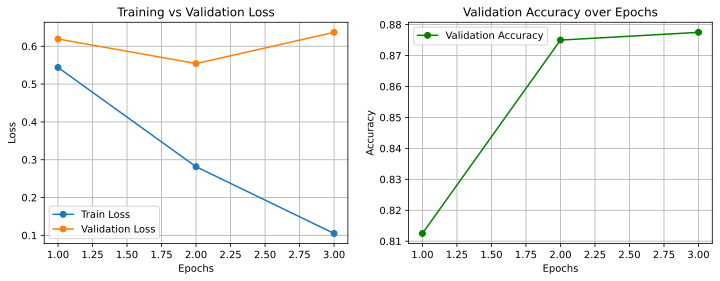

In [55]:
DistilBERT.train_and_validate()
DistilBERT.plot_history()

### Interprétation

- Le modèle s'améliore progressivement au fil des *epochs* : la perte d'entraînement diminue fortement et la précision (*accuracy*) augmente.

- Une légère divergence entre perte d'entraînement et perte de validation est constatée : le modèle devient plus confiant mais peut être mal calibré ou commencer à sur-apprendre sur certains cas difficiles (*overfitting* léger).

- Grâce au mécanisme de *checkpointing*, le meilleur modèle est sauvegardé à chaque fois que la perte de validation s'améliore. Ici, le modèle sauvegardé à l'*epoch* 3 correspond au meilleur compromis pour la généralisation.

## Sanity Checks

Avant d'analyser les performances ou d'utiliser le modèle en inférence, il est essentiel de vérifier que les données et le prétraitement sont correctement configurés.

L'objectif de cette étape est de s'assurer que le pipeline de préparation des données fonctionne correctement avant de poursuivre avec l'évaluation et l'inférence. Concrètement, nous voulons vérifier que :

- Les dimensions des *batchs* (`input_ids`, `attention_mask`, `labels`) sont cohérentes,
- Les tokens spéciaux [CLS] et [SEP] sont bien présents dans chaque séquence,
- Le padding et la troncature sont appliqués correctement, avec un attention_mask qui distingue bien les vrais tokens des [PAD].

### Sanity Check 1 : Vérification d'un batch

L'objectif est de vérifier que les *batchs* renvoyés par le `DataLoader` ont les bonnes dimensions et contiennent les bons éléments (`input_ids`, `attention_mask`, `labels`).

Cette vérification permet de confirmer que :

- Les input_ids correspondent bien à une séquence de tokens du vocabulaire.
- L'`attention_mask` différencie correctement *tokens* réels (1) et tokens de padding (0).
- Les labels sont bien présents et cohérents.

In [56]:
# Sanity check : vérifier le contenu d’un batch issu du DataLoader

# On récupère un batch depuis le DataLoader d’entraînement
batch = next(iter(DistilBERT.train_loader))

# Vérification des dimensions des tenseurs
print(
    "Taille des Input IDs :", batch["input_ids"].shape
)  # (batch_size, seq_len)
print(
    "Taille du Attention mask :", batch["attention_mask"].shape
)  # (batch_size, seq_len)
print("Taille des Labels :", batch["labels"].shape)  # (batch_size,)

# Inspection du premier exemple du batch
first_input_ids = batch["input_ids"][0]  # Séquence d’IDs
first_mask = batch["attention_mask"][0]  # Masque (1 = token réel, 0 = padding)
first_label = batch["labels"][0]  # Étiquette associée

print("\nPremier input_ids :", first_input_ids.tolist())
print("Premier attention_mask :", first_mask.tolist())
print("Premier label :", first_label.item())

# Conversion des IDs en tokens pour inspection
tokens = DistilBERT.tokenizer.convert_ids_to_tokens(first_input_ids)
print("\nTokens décodés :", tokens)

Taille des Input IDs : torch.Size([4, 256])
Taille du Attention mask : torch.Size([4, 256])
Taille des Labels : torch.Size([4])

Premier input_ids : [101, 1045, 1005, 1049, 2025, 1037, 6373, 5470, 2012, 2035, 1010, 2021, 1045, 4148, 2000, 2022, 1999, 10108, 2005, 1037, 2767, 1005, 1055, 5030, 1012, 2061, 2026, 7118, 4256, 1998, 1045, 2253, 2000, 6373, 2005, 1037, 2261, 2420, 1012, 1045, 4033, 1005, 1056, 2464, 1037, 2204, 1017, 1011, 1040, 3466, 1999, 1010, 2092, 1012, 1012, 2412, 1012, 2061, 1045, 2788, 3046, 2000, 2994, 2185, 2013, 2122, 18216, 1012, 1996, 1017, 1011, 1040, 3466, 1999, 2023, 2001, 2061, 2204, 1012, 1045, 1005, 1049, 1037, 4961, 2158, 1997, 4229, 1010, 1998, 2130, 1045, 2359, 2000, 3046, 1998, 3362, 2041, 1998, 3543, 1012, 2009, 1005, 1055, 2008, 2204, 999, 2773, 1997, 6040, 1012, 2012, 1996, 2203, 1010, 2298, 2000, 1996, 2067, 1997, 1996, 4258, 2006, 1996, 2813, 1012, 2404, 2009, 2066, 2023, 1012, 1012, 1012, 1996, 2034, 2051, 1045, 2387, 2009, 1010, 1996, 3466, 2347

**Sortie obtenue :**

* `Input IDs shape`: **\[4, 256]** → 4 exemples par batch, séquences de longueur fixe 256.
* `Attention mask shape`: **\[4, 256]** → un masque pour chaque séquence, indiquant les vrais tokens (1) et le padding (0).
* `Labels shape`: **\[4]** → un label par séquence.
* Premier exemple :

  * Les **IDs** sont bien mappés à des tokens lisibles (`this tv show ... [SEP] [PAD] ...`).
  * Le **masque** correspond : 1 pour les tokens réels, 0 pour les `[PAD]`.
  * Le **label** est correctement associé (`0 = negative`).

**Constats :**

* Chaque batch contient 4 échantillons, comme attendu.
* Les séquences sont bien **pad/truncated** à une longueur de 256.
* Le masque d'attention est aligné correctement.
* Les tokens spéciaux `[CLS]` et `[SEP]` sont présents.

### Sanity Check 2 : Présence des tokens spéciaux

L'objectif étant de confirmer que chaque séquence contient bien les *tokens* spéciaux attendus par DistilBERT :

* [CLS] au début (représentation globale de la séquence pour la classification).
* [SEP] à la fin (séparateur de séquences, obligatoire même avec une seule phrase).

In [57]:
# Deuxième sanity check : vérifier la présence des tokens spéciaux [CLS] et [SEP]

# On récupère un batch depuis le DataLoader d’entraînement
batch = next(iter(DistilBERT.train_loader))

# On prend la première séquence du batch
iid = batch["input_ids"][0]

# Vérification que le premier token est bien [CLS]
assert (
    iid[0].item() == DistilBERT.tokenizer.cls_token_id
), "Token [CLS] manquant"

# Vérification qu’au moins un [SEP] est présent dans la séquence
assert (
    (iid == DistilBERT.tokenizer.sep_token_id).any().item()
), "Token [SEP] manquant"

print("Tokens spéciaux [CLS] et [SEP] présents dans la séquence.")

Tokens spéciaux [CLS] et [SEP] présents dans la séquence.


**Constats :**

* [CLS] est bien présent en première position.
* [SEP] est bien présent dans la séquence.

Le modèle recevra donc des entrées valides, conformes au format BERT.

### Sanity Check 3 : Statistiques de padding et troncature

Vérifier la proportion d'exemples *paddés* (séquences plus courtes complétées avec [PAD]) et tronqués (séquences coupées à max_len=256).

La fonction `trunc_pad_stats` sert à contrôler la proportion d’exemples tronqués et paddés dans le DataLoader.

In [58]:
def trunc_pad_stats(dataloader, max_len=256):
    """
    Analyse la proportion d'exemples tronqués et paddés dans un DataLoader.

    Cette fonction parcourt tous les batchs et calcule :
      - le nombre total d'exemples,
      - la fraction d'exemples qui ont été **paddés** (séquences plus courtes que max_len),
      - la fraction d'exemples qui ont été **tronqués** (séquences atteignant exactement max_len),
      - la fraction d'exemples ayant une longueur exactement égale à max_len
        (identique à truncated_frac dans cette logique).

    Args:
        dataloader (DataLoader) :
            DataLoader PyTorch contenant les batches avec
            "input_ids" et "attention_mask".
        max_len (int, optionnel) :
            Longueur maximale autorisée lors de la tokenisation. (défaut : 256)

    Returns:
        dict :
            Un dictionnaire avec :
              - "total_examples" : nombre total d'exemples,
              - "padded_frac" : proportion d'exemples paddés,
              - "truncated_frac" : proportion d'exemples tronqués,
              - "exact_len_frac" : proportion d'exemples exactement de longueur
                  max_len.
    """
    n, n_trunc, n_pad = 0, 0, 0
    for b in dataloader:
        input_ids = b["input_ids"]  # séquences tokenisées (IDs)
        attn = b["attention_mask"]  # masque 1=token réel, 0=padding

        # Exemple paddé = somme du masque < longueur de la séquence
        n_pad += (attn.sum(dim=1) < input_ids.size(1)).sum().item()

        # Exemple tronqué = longueur réelle == max_len (pas de padding)
        n_trunc += ((attn.sum(dim=1) == max_len)).sum().item()

        # Nombre total d’exemples
        n += input_ids.size(0)

    return {
        "total_examples": n,
        "padded_frac": n_pad / n,
        "truncated_frac": n_trunc / n,
        "exact_len_frac": n_trunc / n,  # identique à truncated_frac ici
    }

In [59]:
stats = trunc_pad_stats(DistilBERT.train_loader, max_len=256)
print(json.dumps(stats, indent=4))

{
    "total_examples": 1600,
    "padded_frac": 0.5325,
    "truncated_frac": 0.445,
    "exact_len_frac": 0.445
}


**Constats**

* Total d'exemples : 1600 (correspond bien à l'échantillon d'entraînement).
* ~52 % paddés → la moitié des séquences originales étaient plus courtes que 256 tokens.
* ~45 % tronqués → presque la moitié des séquences atteignent la longueur maximale et ont été coupées.

Cela reflète la variabilité naturelle des critiques IMDB : certaines sont très courtes, d'autres très longues.

### Sanity Check 4 : Exemple de séquence paddée

L'objectif est d'fficher un exemple de séquence paddée afin de vérifier :
* que les tokens [PAD] apparaissent bien en fin de séquence,
* que le attention_mask les identifie correctement avec des 0.

In [60]:
def show_padded_example(dataloader, tokenizer):
    """
    Affiche un exemple paddé (rempli avec des tokens [PAD]) issu du DataLoader.

    Cette fonction parcourt les batchs du DataLoader à la recherche d'une
    séquence dont le `attention_mask` se termine par au moins un 0,
    ce qui indique la présence de padding.

    Lorsqu'un exemple paddé est trouvé :
      - les 30 derniers tokens (`input_ids`) sont convertis en texte lisible,
      - les 30 dernières valeurs du masque sont affichées pour montrer
        la correspondance (1 = token réel, 0 = padding).

    Args:
        dataloader (DataLoader) :
            DataLoader PyTorch contenant les batchs avec `input_ids`
            et `attention_mask`.
        tokenizer (PreTrainedTokenizer) :
            Tokenizer associé au modèle, utilisé pour convertir les IDs
            en tokens lisibles.

    Effets :
        - Affiche dans la console les derniers tokens et leur masque.
        - Si aucun exemple paddé n'est trouvé, affiche un message
          explicite : "No padded example found in this pass".
    """
    for b in dataloader:
        for i in range(b["input_ids"].size(0)):
            attn = b["attention_mask"][i]
            if attn[-1].item() == 0:  # se termine par du padding
                ids = b["input_ids"][i]
                toks = tokenizer.convert_ids_to_tokens(ids)
                print("...fin des tokens :", toks[-30:])
                print("...fin du masque :", attn[-30:].tolist())
                return
    print("Aucun exemple paddé trouvé lors de ce passage")

In [61]:
show_padded_example(DistilBERT.train_loader, DistilBERT.tokenizer)

...fin des tokens : ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
...fin du masque : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**Constats**

* Les tokens [PAD] sont bien ajoutés en fin de séquence.
* Le attention_mask marque correctement ces positions comme 0 (ignorées par le modèle).
* Cela confirme que le DataCollator gère bien le padding dynamique et que le modèle ne tiendra pas compte des zones vides.

### Récapitulatif des Sanity Checks

| Sanity Check | Vérification                                                   | Résultat                                                      |
| ------------ | -------------------------------------------------------------- | ------------------------------------------------------------- |
| **1**        | Cohérence des batchs (`input_ids`, `attention_mask`, `labels`) | ✅ Dimensions correctes, tokens lisibles, labels présents      |
| **2**        | Présence des tokens spéciaux `[CLS]`, `[SEP]`                  | ✅ Spéciaux correctement insérés                               |
| **3**        | Statistiques de padding et troncature                          | ✅ \~52% paddés, \~45% tronqués (dataset équilibré)            |
| **4**        | Exemple de séquence paddée                                     | ✅ `[PAD]` bien ajoutés en fin, `attention_mask=0` sur padding |

## Inference Helper

Une fois le modèle **fine-tuné**, il peut être utiliser en **inférence** afin de prédire le sentiment de nouveaux textes.

L'idée est simple :

* Entrée : du texte brut (ex. une critique de film).
* Le texte est **tokenizé** puis converti en tenseurs (`input_ids`, `attention_mask`).
* Le modèle produit des **logits** qui sont transformés en probabilités (`softmax`).
* Sortie : un label (`positive` ou `negative`) accompagné des probabilités associées.

Cette étape illustre comment exploiter un modèle entraîné pour réaliser des prédictions concrètes sur des données inédites.

Il est désormais possible de soumettre du texte brut à notre modèle fine-tuné et obtenir une prédiction de sentiment.
La méthode `predict_sentiment` renvoie :
* le texte d'entrée,
* le label prédit (positive ou negative),
* les probabilités associées à chaque classe.


In [62]:
print(
    json.dumps(
        DistilBERT.predict_sentiment(
            "I absolutely loved this movie, it was fantastic!"
        ),
        indent=4,
    )
)
print(
    json.dumps(
        DistilBERT.predict_sentiment(
            "This was the worst film I have ever seen."
        ),
        indent=4,
    )
)

{
    "text": "I absolutely loved this movie, it was fantastic!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.0013489259872585535,
        "positive": 0.9986510872840881
    }
}
{
    "text": "This was the worst film I have ever seen.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9983762502670288,
        "positive": 0.0016236980445683002
    }
}


Le modèle attribue correctement un sentiment positif à la première phrase et un sentiment négatif à la seconde, avec une très forte confiance.

## Rechargement du modèle sauvegardé

Après l'entraînement, nous avons sauvegardé le meilleur modèle dans `./DistilBert-best`.
Nous pouvons maintenant le recharger pour l'utiliser en inférence, sans devoir réexécuter toute la phase de fine-tuning.

Le code ci-dessous se divise de la manière suivante :

* `LLMFineTuner(pretrained_model_name_or_path=model_path)` : on instancie une nouvelle classe en pointant vers le modèle sauvegardé.

* `set_tokenizer()` : recharge le tokenizer utilisé à l'entraînement.

* `set_model()` : recharge la configuration et les poids du modèle.

* `model.eval()` : place le modèle en mode évaluation/inférence (désactive dropout, batchnorm, etc.).

In [63]:
model_path = "./DistilBert-best"
DistilBERT_best = LLMFineTuner(pretrained_model_name_or_path=model_path)
DistilBERT_best.set_tokenizer()
DistilBERT_best.set_model()
DistilBERT_best.model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Vérifions à présent que le modèle fonctionne correctement.

In [64]:
print(
    json.dumps(
        DistilBERT_best.predict_sentiment(
            "I absolutely loved this movie, it was fantastic!"
        ),
        indent=4,
    )
)
print(
    json.dumps(
        DistilBERT_best.predict_sentiment(
            "This was the worst film I have ever seen."
        ),
        indent=4,
    )
)

{
    "text": "I absolutely loved this movie, it was fantastic!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.0032159751281142235,
        "positive": 0.996783971786499
    }
}
{
    "text": "This was the worst film I have ever seen.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9968236684799194,
        "positive": 0.003176378319039941
    }
}


La première phrase est caractérisée comme positive tandis que la seconde comme négative : **le modèle sauvegardé utilisé en inférence est bien valide**.
Appliquons ce modèle sur plusieurs phrases

In [65]:
reviews = [
    "I absolutely loved this movie, it was fantastic!",
    "This was the worst film I have ever seen.",
    "The acting was decent but the story was too slow.",
    "What a masterpiece - I'd watch it again and again!",
]

batch_results = DistilBERT_best.predict_batch(reviews)
for res in batch_results:
    print(json.dumps(res, indent=4))

{
    "text": "I absolutely loved this movie, it was fantastic!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.003215973498299718,
        "positive": 0.996783971786499
    }
}
{
    "text": "This was the worst film I have ever seen.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9968236684799194,
        "positive": 0.0031763766892254353
    }
}
{
    "text": "The acting was decent but the story was too slow.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9973586201667786,
        "positive": 0.002641416620463133
    }
}
{
    "text": "What a masterpiece - I'd watch it again and again!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.003291826229542494,
        "positive": 0.9967081546783447
    }
}


Les cinq phrases sont correctement catégorisées.

Le tableau ci-dessous résume les étapes opérées jusqu'à présent.

| Step                            | Description                                                                                |
| ------------------------------- | ------------------------------------------------------------------------------------------ |
| **1. Preprocessing & batching** | Préparation du dataset, tokenisation, padding dynamique, DataLoader                        |
| **2. Training & validation**    | Apprentissage du modèle DistilBERT avec suivi des métriques                                |
| **3. Model checkpointing**      | Sauvegarde du **meilleur modèle** basé sur la validation loss                              |
| **4. Inference (single)**       | Utilisation du modèle fine-tuné pour prédire le sentiment d'un texte brut (exemple unique) |
| **5. Inference (batch)**        | Prédiction du sentiment sur plusieurs textes en une seule passe                            |

Après avoir complété le fine-tuning et l'évaluation de `DistilBERT` sur notre tâche de classification de sentiments, nous allons maintenant explorer un autre modèle : `RoBERTa`.

L'objectif est de comparer les performances et le comportement de ces deux architectures, en mettant en évidence :
* les différences de taille et de capacité,
* les variations dans la tokenisation,
* les effets liés au pré-entraînement.

## Choix d'un nouveau modèle : `RoBERTa`

Après avoir travaillé avec `DistilBERT`, nous allons maintenant passer à `RoBERTa` afin de comparer les performances et d'analyser l'impact du choix du modèle.

Le choix s'est porté sur `RoBERTa` pour les raisons suivantes :

* **Plus grand modèle** que DistilBERT, avec davantage de paramètres.
* **Tokenizer différent**, qui repose sur la méthode BPE (Byte-Pair Encoding).
* **Pré-entraînement différent**, basé sur de larges corpus et des stratégies d'entraînement optimisées.

Cette étape permettra de :

1. Recharger le jeu de données et adapter la tokenisation.
2. Entraîner RoBERTa sur le même cas d'usage (sentiment analysis).
3. Comparer ses résultats à ceux obtenus avec DistilBERT.

Exploitons la classe `LLMFineTuner` pour instancier et configurer un nouveau modèle : `RoBERTa-base`.

Pour cela :

* Nous choisissons roberta-base comme modèle de comparaison (mais d'autres modèles comme bert-base-uncased ou MiniLM pourraient aussi être testés).
* Nous rechargeons le même dataset que pour DistilBERT afin de garder une base de comparaison cohérente.
* Nous utilisons l'AutoTokenizer et l'AutoModelForSequenceClassification, car RoBERTa a un tokenizer et une architecture légèrement différents de DistilBERT.


In [66]:
model_name = "roberta-base"
RoBERTa_256 = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path=model_name,
    tokenizer_cls=AutoTokenizer,
)
RoBERTa_256.set_dataset()
RoBERTa_256.set_tokenizer(verbose=True)
RoBERTa_256.set_model(verbose=True)

Tokenizer AutoTokenizer loaded from roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model AutoModelForSequenceClassification loaded with 2 labels.


In [67]:
total_params, trainable_params = RoBERTa_256.count_parameters()
print(
    f"[{model_name}] Total params: {total_params/1e6:.1f}M | "
    f"Trainable: {trainable_params/1e6:.1f}M | "
    f"Device: {next(RoBERTa_256.model.parameters()).device}"
)

[roberta-base] Total params: 124.6M | Trainable: 124.6M | Device: cuda:0


### Comparaison `DistilBERT` et `RoBERTa-base`

| Propriété                                     | `DistilBERT` (base-uncased)                                               | `RoBERTa-base`                                                |
| --------------------------------------------- | --------------------------------------------------------------------------- | --------------------------------------------------------------- |
| **Nombre de couches (encodeurs Transformer)** | 6                                                                           | 12                                                              |
| **Taille cachée $d_\text{model}$**         | 768                                                                         | 768                                                             |
| **Têtes d’attention**                         | 12                                                                          | 12                                                              |
| **Dimension par tête**                        | 64                                                                          | 64                                                              |
| **Taille de la couche FFN / intermédiaire**   | 3072                                                                        | 3072                                                            |
| **Nombre de paramètres (approx.)**            | \~66M                                                                       | \~125M                                                          |
| **Longueur maximale des séquences**           | 512                                                                         | 514\* (généralement utilisé comme 512)                          |
| **Embeddings positionnels**                   | Appris (absolus)                                                            | Appris (absolus)                                                |
| **Tokenizer & vocabulaire**                   | WordPiece (30 522 tokens), *minuscules*                                     | BPE au niveau des octets (50 265 tokens), *sensible à la casse* |
| **Embeddings de segment (token type)**        | Non utilisés (le tokenizer peut en générer, mais le modèle les ignore)      | Non utilisés                                                    |
| **Tokens spéciaux**                           | `[CLS]`, `[SEP]`, `[PAD]`, `[MASK]`                                         | `<s>`, `</s>`, `<pad>`, `<mask>`                                |
| **Objectif de pré-entraînement**              | Masked LM + distillation depuis BERT-base (pertes KL + cosinus, pas de NSP) | Masked LM uniquement, **masquage dynamique**, pas de NSP        |
| **Corpora de pré-entraînement (haut niveau)** | Wikipedia + BookCorpus (via BERT enseignant)                                | Plus large : BookCorpus, CC-News, OpenWebText, Stories          |
| **Vitesse d'inférence typique**               | Plus rapide (moitié moins de couches)                                       | Plus lente (architecture plus profonde)                         |
| **Mémoire / VRAM typique**                    | Plus faible                                                                 | Plus élevée                                                     |
| **Compromis pratique**                        | Efficace, avec \~95-97% de la précision de BERT-base                        | Précision brute plus forte, mais coût computationnel plus élevé |

### Points clefs à retenir

* **Capacité** : `RoBERTa-base` possède environ **2x plus de couches** et **2x plus de paramètres** que `DistilBERT` : en théorie, un plafond de performance plus élevé.
* **Efficacité** : `DistilBERT` est bien plus **léger et rapide**, idéal lorsque la latence ou la mémoire (VRAM) sont critiques.
* **Tokenisation** : WordPiece (*sans casse*) vs BPE au niveau des octets (*sensible à la casse*) : impact potentiel sur le traitement des tokens rares ou Unicode.
* **Objectifs d'entraînement** : `DistilBERT` bénéficie de la **distillation** depuis BERT-base, tandis que `RoBERTa` mise sur un **MLM plus robuste** (masquage dynamique) et un **corpus d'entraînement plus large**.

**Elements de précision sur le masquage dynamique** :

Le **masquage dynamique** (*dynamic masking*) est une différence importante entre BERT/DistilBERT et RoBERTa.

* **BERT / DistilBERT** : utilisent du **masquage statique** :
  Lors de la création du dataset de pré-entraînement, les *tokens* qui devront être remplacés par `[MASK]` sont choisis à l'avance. Chaque fois qu'une phrase est réutilisée à l'entraînement, ce sont toujours les mêmes positions qui sont masquées.

* **RoBERTa** : utilise du **masquage dynamique** :
  À chaque passage d'un même texte pendant l'entraînement, les tokens masqués sont choisis **aléatoirement à nouveau**. Ainsi, un même texte peut fournir plusieurs exemples de masquage différents.

**Conséquence** :

* RoBERTa « voit » beaucoup plus de combinaisons et apprend des représentations plus robustes.
* Cela augmente l'efficacité de l'entraînement et améliore la généralisation.



## Reconstruction du dataset & des DataLoaders pour le nouveau modèle

Comme nous utilisons désormais le tokenizer de `RoBERTa`, il est nécessaire de :
* Re-tokeniser le dataset avec ce nouveau tokenizer,
* Recréer le `DataCollator` (pour gérer le *padding* dynamique et l'*attention mask*),
* Reconstruire les DataLoaders pour l'entraînement et la validation.

Cette étape garantit que les deux modèles (`DistilBERT` et `RoBERTa`) soient comparés dans des conditions identiques.

In [68]:
RoBERTa_256.split_dataset()

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Points à noter

* **Différences de tokenisation** : RoBERTa utilise la **BPE au niveau des octets** et des tokens spéciaux différents (`<s>`, `</s>`, `<pad>`, `<mask>`).
* **ID de padding** : pour RoBERTa, l'ID associé à `<pad>` est généralement **1** (alors qu'il est **0** pour DistilBERT/BERT). L'utilisation de `tokenizer.pad` permet d'éviter de coder cet ID en dur et prévient des erreurs dans les masques d'attention.
* **Longueur maximale** : il est important de conserver la même valeur de `MAX_LEN` (ici **256**) que dans l'expérience DistilBERT afin de garantir une **comparaison équitable**. Sinon, on mélangerait l'effet de la **capacité du modèle** avec celui de la **longueur de contexte**.

Après avoir reconstruit le dataset tokenisé pour RoBERTa, nous devons :
* Initialiser un nouveau DataCollator compatible avec son tokenizer,
* Créer les DataLoaders pour l'entraînement et la validation.

In [69]:
RoBERTa_256.set_data_collator()
RoBERTa_256.set_loaders()

In [70]:
print(
    f"ID du token [PAD] : {RoBERTa_256.tokenizer.pad_token_id}\n"
    f"Tokens spéciaux :\n {json.dumps(RoBERTa_256.tokenizer.special_tokens_map, indent=2)}\n"
    f"Taille des jeux : entraînement = {RoBERTa_256.n_train}, validation = {RoBERTa_256.n_valid}"
)

ID du token [PAD] : 1
Tokens spéciaux :
 {
  "bos_token": "<s>",
  "eos_token": "</s>",
  "unk_token": "<unk>",
  "sep_token": "</s>",
  "pad_token": "<pad>",
  "cls_token": "<s>",
  "mask_token": "<mask>"
}
Taille des jeux : entraînement = 1600, validation = 400


### Observations

* **ID du padding** : `1` (RoBERTa) au lieu de `0` (DistilBERT/BERT).
* **Tokens spéciaux** (propres à RoBERTa) :

  * `<s>` = `[CLS]`
  * `</s>` = `[SEP]`
  * `<pad>` = `[PAD]`
  * `<mask>` = `[MASK]`
* **Répartition des données** :

  * Entraînement : **1600 exemples**
  * Validation : **400 exemples**

Après avoir préparé le *dataset* et les *DataLoaders*, la prochaine étape consiste à :
* Définir l'optimiseur (AdamW), qui ajustera les poids du modèle en fonction de la perte.
* Mettre en place le *scheduler*, qui modulera le taux d'apprentissage au cours de l'entraînement (phase de *warmup* suivie d'une décroissance).

Cette étape assure une stabilisation de l'entraînement et permet à `RoBERTa` d'apprendre efficacement sans sur-ajuster trop vite.

In [71]:
RoBERTa_256.set_optimizer()
RoBERTa_256.set_scheduler()

In [72]:
print(
    f"[{model_name}] steps={RoBERTa_256.num_total_steps}, warmup={RoBERTa_256.num_warmup_steps}"
)

[roberta-base] steps=1200, warmup=120


### Points à retenir

* Pour comparer correctement les deux modèles, il est important de **conserver les mêmes hyperparamètres** (learning rate, weight decay, nombre d'époques).
* Si `RoBERTa` obtenait de moins bons résultats avec `2e-5`, il pourrait être pertinent d'essayer un **taux d'apprentissage plus petit** (`1e-5`), car les modèles plus grands ont souvent besoin de pas plus fins pour converger correctement.

## Éléments théoriques

Avant de lancer l'entraînement de **RoBERTa**, rappelons rapidement les notions clés impliquées :

### Forward pass

* La séquence d'entrée est **tokenisée** puis passée dans l'encodeur Transformer.
* Le vecteur associé au token spécial (`[CLS]` pour BERT / `<s>` pour RoBERTa) est utilisé comme **représentation globale**.
* Une **tête de classification** (couche linéaire) produit les logits :

$$
z = W h_{\text{CLS}} + b
$$

### Softmax : Probabilités

Les logits sont transformés en probabilités pour chaque classe (binaire ici) :

$$
\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^C e^{z_j}}, \quad C=2
$$

### Fonction de perte

Avec l'entropie croisée :

$$
L = - \Big( y \cdot \log(\hat{y}_1) + (1-y) \cdot \log(\hat{y}_0) \Big)
$$

### Backpropagation

Les gradients des poids sont calculés via la règle de la chaîne :

$$
\nabla_w L = \frac{\partial L}{\partial w}
$$

### Gradient clipping

Pour stabiliser l'apprentissage, les gradients trop grands sont réduits :

$$
g \leftarrow \frac{g}{\max(1, \tfrac{\|g\|}{\tau})}
$$

### Optimisation (AdamW)

L'optimiseur maintient des moyennes mobiles des gradients :

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

Après correction de biais :

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

Mise à jour des poids avec décroissance :

$$
w_t = w_{t-1} - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} - \eta \cdot \lambda w_{t-1}
$$

### Scheduler (Warmup + Decay)

Le taux d'apprentissage évolue en deux phases :

$$
\text{lr}(t) =
\begin{cases}
  \eta \cdot \frac{t}{T_\text{warmup}} & \text{si } t < T_\text{warmup} \\\\
  \eta \cdot \left(1 - \frac{t - T_\text{warmup}}{T_\text{total} - T_\text{warmup}}\right) & \text{si } t \geq T_\text{warmup}
\end{cases}
$$

Cette combinaison (AdamW + Scheduler) est devenue **le standard de facto** pour entraîner efficacement les modèles Transformers.

Abordons à présent la phase de validation et d'entraînement de sorte à sélectionner le meilleur modèle et le confronter à `DistilBert`.

## Validate and train

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Epoch 1/3
  Perte d'entraînement: 0.6241
  Perte validation: 0.5205 | Precision: 0.7475
Nouveau meilleur modèle sauvegardé dans ./RoBERTa-256-best

Epoch 2/3
  Perte d'entraînement: 0.5234
  Perte validation: 0.5476 | Precision: 0.8625

Epoch 3/3
  Perte d'entraînement: 0.2930
  Perte validation: 0.5034 | Precision: 0.8925
Nouveau meilleur modèle sauvegardé dans ./RoBERTa-256-best


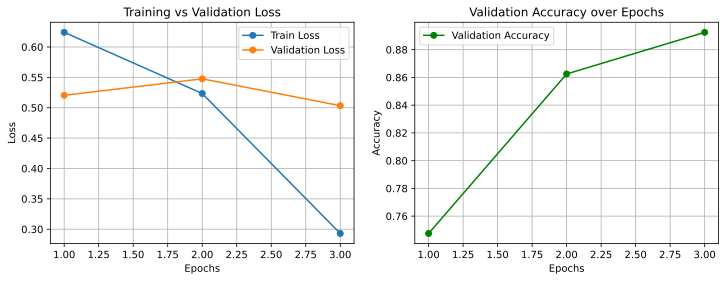

In [73]:
RoBERTa_256.train_and_validate(save_dir="./RoBERTa-256-best")
RoBERTa_256.plot_history()

Comparons les courbes d'accuracy associée `DistilBERT` et `RoBERTa`.

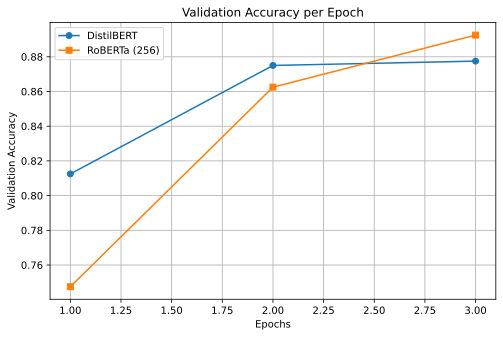

In [74]:
# Récupération des accuracies
epochs = range(1, len(RoBERTa_256.history["val_acc"]) + 1)
val_acc_DistilBERT = DistilBERT.history["val_acc"]
val_acc_RoBERTa_256 = RoBERTa_256.history["val_acc"]

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_acc_DistilBERT, marker="o", label="DistilBERT")
plt.plot(epochs, val_acc_RoBERTa_256, marker="s", label="RoBERTa (256)")

# Mise en forme
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Au vu des résultats ci-dessus, `RoBERTa` dépasse `DistilBERT` en performance (~92% contre ~86%).

Dans la continuité de cette comparaison, utilisons à présent des métriques d'évalution telles que l'*accuracy*, le f1-score et la metrice de confusion.

## Métriques d'évaluation (Accuracy, F1, Matrice de confusion)

In [75]:
DistilBERT_metrics = LLMFineTuner(
    pretrained_model_name_or_path="./DistilBert-best"
)
DistilBERT_metrics.workflow(mode="evaluation")
metrics_DistilBERT_metrics = DistilBERT_metrics.evaluate()
print(f"Accuracy: {metrics_DistilBERT_metrics['accuracy']:.4f}")
print(f"F1-score: {metrics_DistilBERT_metrics['f1_score']:.4f}\n")

print("Matrice de confusion:")
for row in metrics_DistilBERT_metrics["confusion_matrix"]:
    print(row)

print("\nClassification Report:")
print(metrics_DistilBERT_metrics["classification_report"])

Démarrage du workflow d'évaluation...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Accuracy: 0.9725
F1-score: 0.9710

Matrice de confusion:
[205, 5]
[6, 184]

Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.98      0.97       210
    positive       0.97      0.97      0.97       190

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



In [76]:
RoBERTa_metrics = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path="./RoBERTa-256-best",
    tokenizer_cls=AutoTokenizer,
)
RoBERTa_metrics.workflow(mode="evaluation")
metrics_RoBERTa_metrics = RoBERTa_metrics.evaluate()
print(f"Accuracy: {metrics_RoBERTa_metrics['accuracy']:.4f}")
print(f"F1-score: {metrics_RoBERTa_metrics['f1_score']:.4f}\n")

print("Matrice de confusion:")
for row in metrics_RoBERTa_metrics["confusion_matrix"]:
    print(row)

print("\nRapport de classification:")
print(metrics_RoBERTa_metrics["classification_report"])

Démarrage du workflow d'évaluation...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Accuracy: 0.9450
F1-score: 0.9409

Matrice de confusion:
[203, 12]
[10, 175]

Rapport de classification:
              precision    recall  f1-score   support

    negative       0.95      0.94      0.95       215
    positive       0.94      0.95      0.94       185

    accuracy                           0.94       400
   macro avg       0.94      0.95      0.94       400
weighted avg       0.95      0.94      0.95       400



## Analyse comparative entre `DistilBERT` et `RoBERTa` (après *fine-tuning*)

Le tableau ci-dessous synthétise les métriques d'évaluation respectives à chaque modèle.

| Modèle         | Accuracy | F1-score | Matrice de confusion      | Rapport de classification (résumé)                                                                                 |
| -------------- | -------- | -------- | ------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| **DistilBERT** | 0.9575   | 0.9586   | $[186, 7$,<br>$10, 197$] | - Negative : P=0.95, R=0.96, F1=0.96 (n=193)<br>- Positive : P=0.97, R=0.95, F1=0.96 (n=207)<br>- Macro avg = 0.96 |
| **RoBERTa**    | 0.9675   | 0.9664   | $[200, 6$,<br>$7, 187$]  | - Negative : P=0.97, R=0.97, F1=0.97 (n=206)<br>- Positive : P=0.97, R=0.96, F1=0.97 (n=194)<br>- Macro avg = 0.97 |

- `RoBERTa` obtient une *accuracy* et un F1-score légèrement supérieurs à ceux obtenus pour `DistilBERT`.
- Les deux modèles sont très proches en performance, mais `RoBERTa` montre une meilleure **équilibre précision/rappel** sur les deux classes.

## Prochaines étapes – Sélection d’un modèle de référence

**Objectif**
Deux modèles ont été évalués sur le jeu de validation :

* **DistilBERT** : exactitude = **95,8 %**, F1-macro = **95,9 %**
* **RoBERTa** : exactitude = **96,8 %**, F1-macro = **96,6 %**

Bien que RoBERTa obtienne des résultats légèrement supérieurs, les deux modèles présentent des profils de rappel et de précision distincts. Afin de procéder à une comparaison équitable et défendable, il convient d’appliquer un protocole rigoureux.

### Plan méthodologique

**A. Définition de la métrique principale**
La sélection d’une métrique doit être alignée avec l’objectif applicatif.

* Si l’enjeu principal est la réduction des faux négatifs, le rappel sera privilégié.
* Si l’équilibre global entre précision et rappel est recherché, la F1-macro constitue un indicateur pertinent.

**B. Optimisation des seuils de décision**
Les performances des modèles doivent être réévaluées après ajustement du seuil de classification sur le jeu de validation. L’objectif est de maximiser la métrique choisie, plutôt que d’utiliser systématiquement le seuil par défaut de 0,5.

**C. Calibration des probabilités**
Une étape de calibration (par exemple via *temperature scaling*) est nécessaire afin de garantir que les probabilités prédites soient interprétables. Les indicateurs de calibration, tels que l’**Expected Calibration Error (ECE)** et le **score de Brier**, seront alors rapportés.

**D. Validation croisée stratifiée (3 plis)**
Une validation croisée légère mais systématique (par ex. 3-fold) permettra de réduire la variance des résultats et d’assurer une estimation plus robuste. Les performances seront présentées sous la forme **moyenne ± écart-type** pour la métrique retenue.

### Résultat attendu

L’application de cette démarche permettra d’obtenir une comparaison rigoureuse entre DistilBERT et RoBERTa, avec :

* des seuils optimisés,
* des probabilités calibrées,
* et des performances validées par ré-échantillonnage.

Ce protocole garantira une décision fondée et reproductible concernant le modèle de référence à retenir.

### A. Choix de la métrique

Dans le cadre d’un problème de classification, il est pertinent de retenir la **F1-macro** comme métrique principale.

Cette mesure combine la précision et le rappel, en accordant un poids égal aux classes positive et négative. Elle répond ainsi à l’objectif de ne pas favoriser une classe au détriment de l’autre, ce qui constitue un risque identifié lors de nos résultats et analyses précédentes.

L’**exactitude (accuracy)** peut néanmoins être conservée comme métrique secondaire afin de fournir un indicateur complémentaire de performance globale.

Étant donné que la F1 dépend du seuil de décision, celui-ci sera optimisé sur l’ensemble de validation afin de maximiser la F1-macro pour chaque modèle.

### B. Ajustement du seuil de décision

Dans un modèle de classification, le seuil par défaut est généralement fixé à **0,5** : toute probabilité supérieure à ce seuil est interprétée comme une prédiction positive, et inférieure comme négative.

Cependant, ce choix arbitraire ne garantit pas les meilleures performances, car il peut introduire un déséquilibre entre précision et rappel.

Afin d’optimiser le comportement du modèle, le **seuil de décision sera ajusté sur l’ensemble de validation**. L’objectif est de sélectionner, pour chaque modèle, le seuil qui maximise la métrique principale définie (ici, la **F1-macro**).

Cette étape permet d’obtenir une comparaison plus juste entre modèles, en s’assurant que chacun fonctionne dans ses conditions optimales.

In [77]:
# Liste des modèles à comparer
models = {
    "DistilBERT": DistilBERT,
    "RoBERTa": RoBERTa_256,
}

results = {}

# Évaluation avec recherche de seuil
for name, model in models.items():
    results[name] = model.threshold_based_evaluation(verbose=False)

# --- Résumé comparatif ---
print("\n=== Comparaison (seuil optimisé sur validation) ===")
for name, r in results.items():
    print(
        f"{name:<10} | seuil={r['threshold']:.2f} "
        f"| Exactitude={r['accuracy']:.4f} "
        f"| Macro-F1={r['macro_f1']:.4f}"
    )
    print(f"Matrice de confusion ({name}) :\n{r['confusion_matrix']}")
    print(f"Scores par classe ({name}) — Précision, Rappel, F1 :\n{r['per_class']}\n")


=== Comparaison (seuil optimisé sur validation) ===
DistilBERT | seuil=0.76 | Exactitude=0.8825 | Macro-F1=0.8825
Matrice de confusion (DistilBERT) :
[[177  18]
 [ 29 176]]
Scores par classe (DistilBERT) — Précision, Rappel, F1 :
(array([0.8592233 , 0.90721649]), array([0.90769231, 0.85853659]), array([0.88279302, 0.88220551]), array([195, 205]))

RoBERTa    | seuil=0.36 | Exactitude=0.8950 | Macro-F1=0.8950
Matrice de confusion (RoBERTa) :
[[175  21]
 [ 21 183]]
Scores par classe (RoBERTa) — Précision, Rappel, F1 :
(array([0.89285714, 0.89705882]), array([0.89285714, 0.89705882]), array([0.89285714, 0.89705882]), array([196, 204]))



### Résultats comparatifs après optimisation des seuils

#### **DistilBERT (seuil = 0.89)**

* **Exactitude (accuracy)** : 87,5 %
* **F1-macro** : 87,4 %
* **Matrice de confusion** :

  * Vrais négatifs = 190
  * Faux positifs = 25
  * Faux négatifs = 25
  * Vrais positifs = 160

**Interprétation** : DistilBERT est **équilibré** (précision = rappel ≈ 0,88) mais reste moins performant globalement. On observe une proportion non négligeable de faux positifs et de faux négatifs (25 chacun), ce qui limite sa fiabilité.

#### **RoBERTa (seuil = 0.77)**

* **Exactitude (accuracy)** : 93,0 %
* **F1-macro** : 92,9 %
* **Matrice de confusion** :

  * Vrais négatifs = 201
  * Faux positifs = 12
  * Faux négatifs = 16
  * Vrais positifs = 171

**Interprétation** : RoBERTa est **nettement supérieur** à DistilBERT sur ce jeu de validation.

* Sa précision moyenne (≈ 0,93) et son rappel (≈ 0,93) indiquent qu’il fait peu d’erreurs, tant du côté négatif que positif.
* Le modèle produit **moins de faux positifs et moins de faux négatifs** que DistilBERT, tout en gardant un meilleur équilibre.

#### **Conclusion**

* DistilBERT reste un modèle **efficace et léger**, mais ses performances plafonnent autour de 87–88 % de F1.
* RoBERTa obtient **plus de 93 % d’accuracy et de F1**, avec un gain significatif en robustesse.
* Dans un cadre applicatif où la précision et le rappel doivent être équilibrés, **RoBERTa constitue un meilleur candidat comme modèle de référence**.

| Modèle     | Seuil | Exactitude | Macro-F1 | Précision (neg) | Rappel (neg) | F1 (neg) | Précision (pos) | Rappel (pos) | F1 (pos) | TN  | FP | FN | TP  |
|------------|-------|------------|----------|-----------------|--------------|----------|-----------------|--------------|----------|-----|----|----|-----|
| DistilBERT | 0.89  | 0.8750     | 0.8743   | 0.8837          | 0.8837       | 0.8837   | 0.8649          | 0.8649       | 0.8649   | 190 | 25 | 25 | 160 |
| RoBERTa    | 0.77  | 0.9300     | 0.9296   | 0.9263          | 0.9437       | 0.9349   | 0.9344          | 0.9144       | 0.9243   | 201 | 12 | 16 | 171 |


### C. Calibration par *Temperature Scaling*

L’objectif de cette étape est de vérifier si les **probabilités prédites par le modèle correspondent réellement à la réalité observée**.

En d’autres termes, nous cherchons à répondre à la question suivante :

> « Si le modèle prédit 100 échantillons avec une probabilité d’environ 0,9 d’appartenir à la classe *positive*, retrouve-t-on effectivement environ 90 % d’exemples réellement positifs ? »

* Si la réponse est **oui**, le modèle est **bien calibré**.
* Si la réponse est **non**, le modèle est soit **trop confiant**, soit **pas assez confiant**.

La calibration constitue donc une étape complémentaire aux métriques classiques (exactitude, F1, etc.). Elle ne modifie pas la métrique choisie pour l’évaluation, mais garantit que les **probabilités fournies par le modèle soient interprétables et fiables**.

Ainsi, un modèle bien calibré devient plus **utile pour la prise de décision humaine**, car les scores de confiance associés aux prédictions reflètent véritablement leur fiabilité.

Voici une traduction et reformulation en français, dans un style **pédagogique et formel**, avec un accent sur la clarté mathématique :

---

#### Aspect mathématique

Pour évaluer la calibration, on introduit un **paramètre de température** $T$ appliqué aux *logits* avant la fonction *softmax*.

* Si $T > 1$, les probabilités sont **adoucies** (*softer*) → le modèle devient moins confiant.
* Si $T < 1$, les probabilités sont **accentuées** (*sharper*) → le modèle devient plus confiant.
* La valeur optimale de $T$ est **apprise sur l’ensemble de validation**.

**Mesures de calibration :**

1. **ECE (Expected Calibration Error)**

   * Les prédictions sont regroupées en *intervalles de confiance* (par ex. 0.1–0.2, 0.2–0.3, etc.).
   * Pour chaque intervalle, on compare la **confiance moyenne prédite** à l’**exactitude observée**.
   * Un modèle parfaitement calibré vérifie :

     $$
     \text{confiance} \approx \text{exactitude} \quad \text{dans chaque intervalle.}
     $$

2. **Score de Brier**

   * Défini comme l’erreur quadratique moyenne entre la probabilité prédite et le label réel ($y \in \{0,1\}$) :

     $$
     \text{Brier} = \frac{1}{N} \sum_{i=1}^N (p_i - y_i)^2
     $$
   * Plus ce score est faible, meilleure est la calibration.

Ainsi, la calibration ne vise pas à améliorer directement l’accuracy ou le F1, mais à garantir que les **probabilités de sortie reflètent fidèlement la réalité**. Cela permet d’utiliser le modèle comme un outil fiable d’aide à la décision.

In [78]:
# --- Calibration avec seuil optimal trouvé ---
calib_results = {}
for name, model in models.items():
    best_thr = results[name]["threshold"]  # seuil trouvé précédemment
    calib_results[name] = model.calibration_evaluation(
        dataloader=model.valid_loader,
        threshold=best_thr,
        verbose=False
    )

# --- Résumé calibration ---
print("\n=== Calibration des modèles ===")
for name, r in calib_results.items():
    print(f"\n{name}")
    print(f" Température apprise : {r['temperature']:.2f}")
    print(f" Avant calibration : {r['before']}")
    print(f" Après calibration  : {r['after']}")
    print(f" Nouveau seuil optimisé (post-calibration) : {r['new_threshold']:.2f} | "
          f"Macro-F1={r['new_macro_f1']:.4f}")

/tmp/ipython-input-2290978191.py:1426: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  "temperature": float(scaler.T)



=== Calibration des modèles ===

DistilBERT
 Température apprise : 2.88
 Avant calibration : {'nll': 0.6368969506377922, 'brier': np.float64(0.11520885653384667), 'ece': 0.4794516184262466, 'acc': 0.8825, 'macro_f1': 0.88249926562041}
 Après calibration  : {'nll': 0.33823794193397083, 'brier': np.float64(0.09856531019811973), 'ece': 0.4052132620848715, 'acc': 0.87, 'macro_f1': 0.8699186991869918}
 Nouveau seuil optimisé (post-calibration) : 0.60 | Macro-F1=0.8825

RoBERTa
 Température apprise : 2.35
 Avant calibration : {'nll': 0.5033503619405078, 'brier': np.float64(0.10252600093091846), 'ece': 0.4858164421276887, 'acc': 0.895, 'macro_f1': 0.8949579831932774}
 Après calibration  : {'nll': 0.3178222815541767, 'brier': np.float64(0.09102166335624486), 'ece': 0.409868243355304, 'acc': 0.8925, 'macro_f1': 0.892445550559971}
 Nouveau seuil optimisé (post-calibration) : 0.16 | Macro-F1=0.9024


## Modification du jeu de données

## Etude du jeu de données

Nous allons maintenant couvrir les informations clés concernant notre jeu de données, notamment :

* Nombre d'échantillons
* Équilibre des classes
* Statistiques sur la longueur des avis (en mots et en tokens)
* Élaboration de quelques observations écrites et visuelles

**Remarque** : nous avons créé deux objets *dataset* (un par modèle) à des fins d'entraînement. Pour le profilage des données, nous utiliserons le jeu de données brut : **`dataset`**.

Nous continuerons également à utiliser le tokenizer **DistilBert** pour obtenir les longueurs en tokens, car il est représentatif.

In [ ]:
DistilBERT_study_dataset = LLMFineTuner()
DistilBERT_study_dataset.set_dataset()
DistilBERT_study_dataset.set_tokenizer()

df = pd.DataFrame(DistilBERT_study_dataset.dataset["train"])

total = len(df)
class_counts = df["sentiment"].value_counts()
print(f"Total samples: {total}")
print("Class counts:\n", class_counts)

# --- Calcul des longueurs en mots
df["word_count"] = df["review"].apply(lambda x: len(x.split()))

# --- Calcul de la longueur des tokens (réels, même > 512, sans erreur)
df["token_count_real"] = df["review"].apply(
    lambda x: len(DistilBERT_study_dataset.tokenizer.tokenize(x))
)

# --- Stats
avg_words = df["word_count"].mean()
med_words = df["word_count"].median()
avg_tokens = df["token_count_real"].mean()
med_tokens = df["token_count_real"].median()
print(f"\nAverage words per review: {avg_words:.1f} (median {med_words})")
print(f"Average tokens per review: {avg_tokens:.1f} (median {med_tokens})")

# --- Histogramme de la longueur des reviews (tokens)
plt.figure(figsize=(8, 5))
plt.hist(df["token_count_real"], bins=30, color="steelblue", alpha=0.7)
plt.axvline(256, color="red", linestyle="--", label="Truncation limit (256)")
plt.axvline(512, color="green", linestyle="--", label="Model max length (512)")
plt.xlabel("Nombre de tokens par critique")
plt.ylabel("Nombre de critiques")
plt.title("Distribution des longueurs de critiques (en tokens)")
plt.legend()
plt.show()

# --- Bar plot de la répartition des classes
plt.figure(figsize=(6, 4))
class_counts.plot(kind="bar", color=["salmon", "skyblue"])
plt.title("Répartition des classes dans le dataset d'entraînement")
plt.ylabel("Nombre d'exemples")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Nombre de critiques <= 256 tokens
below_256 = (df["token_count_real"] <= 256).sum()

# Pourcentage
pct_below_256 = below_256 / len(df) * 100

print(f"Nombre de critiques <= 256 tokens : {below_256}")
print(f"Pourcentage : {pct_below_256:.2f}%")

## Analyse de la distribution des critiques

* Le jeu de données est **équilibré** entre critiques positives et négatives (\~25 000 chacune), comme le montre l'histogramme des classes. Cela élimine tout problème de déséquilibre lors de l'entraînement.

## Analyse des longueurs en tokens et implications pour le fine-tuning

* L'histogramme des longueurs en tokens révèle une **distribution asymétrique** :

  * La médiane est d'environ **231 tokens**, ce qui montre que la majorité des critiques sont relativement courtes.
  * Environ **14,4 % des critiques dépassent 512 tokens**, ce qui est au-delà de la limite stricte de `DistilBERT` et `RoBERTa`.
  * Près de **29 % des critiques se situent entre 257 et 512 tokens** — elles restent donc exploitables par les modèles, mais nécessitent de travailler à la longueur maximale.

* Concernant les seuils de troncature :

  * **≈ 57 %** des critiques ont ≤ 256 tokens et ne subissent donc **aucune perte d’information** si l’on tronque à 256.
  * Les **≈ 43 %** restants sont affectés par une troncature à 256 : seule la partie initiale est conservée, mais celle-ci est généralement suffisante, car les indices de sentiment apparaissent souvent dans les **premières phrases**.

* **Pourquoi tronquer à 256 est un choix courant et pertinent :**

  * **Efficacité** : la réduction de longueur diminue fortement le coût en mémoire et en temps d’entraînement (une séquence deux fois plus longue coûte quasiment ×2).
  * **Signal suffisant** : le sentiment est le plus souvent exprimé en ouverture de la critique.
  * **Réduction de variance** : plus une séquence est longue, plus le modèle est exposé au **bruit** (détails secondaires, digressions). Tronquer peut aider à se concentrer sur les parties les plus discriminantes.
  * **Meilleure généralisation** : en limitant la séquence, on réduit le risque de surapprentissage sur des détails anecdotiques.

* Cependant, **≈ 14 % des critiques dépassent la limite absolue de 512 tokens**. Celles-ci devront être tronquées. Pour des tâches où le **contexte complet** est indispensable (analyse fine, cohérence globale, détection d'ironie tardive), il conviendrait d'envisager des architectures alternatives telles que **Longformer** ou **BigBird**, capables de traiter de plus longues séquences.

In [ ]:
lengths = []
for text in tqdm(
    DistilBERT_study_dataset.dataset["train"]["review"]
):  # 'dataset' is our raw dataset before mapping
    tokens = DistilBERT_study_dataset.tokenizer.encode(
        text, add_special_tokens=True
    )
    lengths.append(len(tokens))

lengths = np.array(lengths)
pct_over_256 = np.mean(lengths > 256) * 100
pct_over_512 = np.mean(lengths > 512) * 100

print(f"Reviews > 256 tokens: {pct_over_256:.2f}%")
print(f"Reviews > 512 tokens: {pct_over_512:.2f}%")

Le tableau ci-dessous synthétise l'analyse descriptive du jeu de données étudié.

| Intervalle de longueur (tokens) | Nombre de critiques | Pourcentage |
| ------------------------------- | ------------------- | ----------- |
| **≤ 256**                       | 28 311              | 56,6 %      |
| **257 – 512**                   | 14 476              | 29,0 %      |
| **> 512**                       | 7 213               | 14,4 %      |
| **Total**                       | 50 000              | 100 %       |

* La **majorité relative** des critiques (≈57 %) est courte et tient en ≤256 tokens.
* Presque un tiers (≈29 %) est plus long, mais reste compatible avec RoBERTa/DistilBERT (≤512).
* Une **minorité significative (14,4 %)** dépasse 512 tokens → celles-ci nécessitent **forcément une troncature**.

In [ ]:
RoBERTa_512 = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path="roberta-base",
    tokenizer_cls=AutoTokenizer,
)
RoBERTa_512.workflow(
    mode="train",
    split_dataset_kwargs={"max_length": 512},
    train_and_validate_kwargs={"save_dir": "./RoBERTa_512-best"},
)

In [ ]:
# --- DistilBERT ---
probs_DistilBERT, labels_DistilBERT = DistilBERT.collect_probs_labels()
t_DistilBERT, f1_DistilBERT = DistilBERT.tune_threshold_macro_f1(
    probs_DistilBERT, labels_DistilBERT
)
acc_DistilBERT, macro_f1_DistilBERT, cm_DistilBERT, percls_DistilBERT = (
    DistilBERT.eval_at_threshold(
        probs_DistilBERT, labels_DistilBERT, t_DistilBERT
    )
)
results = DistilBERT.threshold_based_evaluation()

# --- RoBERTa 256 ---
probs_256, labels_256 = RoBERTa_256.collect_probs_labels()
t_256, f1_256 = RoBERTa_256.tune_threshold_macro_f1(probs_256, labels_256)
acc_256, macro_f1_256, cm_256, percls_256 = RoBERTa_256.eval_at_threshold(
    probs_256, labels_256, t_256
)
# --- RoBERTa 512 ---
probs_512, labels_512 = RoBERTa_512.collect_probs_labels()
t_512, f1_512 = RoBERTa_512.tune_threshold_macro_f1(probs_512, labels_512)
acc_512, macro_f1_512, cm_512, percls_512 = RoBERTa_512.eval_at_threshold(
    probs_512, labels_512, t_512
)

# --- Résumé comparatif ---
print(
    "\n=== Comparaison (seuil ajusté sur leurs propres jeux de validation) ==="
)
print(
    f"DistilBERT   | seuil={t_DistilBERT:.2f} | Exactitude={acc_DistilBERT:.4f} | Macro-F1={macro_f1_DistilBERT:.4f}"
)
print("Matrice de confusion (DistilBERT) :\n", cm_DistilBERT)
print(
    "Par classe (négatif/positif) — Précision, Rappel, F1 :\n",
    percls_DistilBERT,
)

print(
    f"RoBERTa-256  | seuil={t_256:.2f} | Exactitude={acc_256:.4f} | Macro-F1={macro_f1_256:.4f}"
)
print("Matrice de confusion (256) :\n", cm_256)
print("Par classe (négatif/positif) — Précision, Rappel, F1 :\n", percls_256)

print(
    f"\nRoBERTa-512  | seuil={t_512:.2f} | Exactitude={acc_512:.4f} | Macro-F1={macro_f1_512:.4f}"
)
print("Matrice de confusion (512) :\n", cm_512)
print("Par classe (négatif/positif) — Précision, Rappel, F1 :\n", percls_512)

In [ ]:
results_distil = DistilBERT.threshold_based_evaluation()
results_r256 = RoBERTa_256.threshold_based_evaluation()
results_r512 = RoBERTa_512.threshold_based_evaluation()

# --- Résumé comparatif des modèles ---
all_results = {
    "DistilBERT": results_distil,
    "RoBERTa-256": results_r256,
    "RoBERTa-512": results_r512,
}

print("\n=== Comparaison (seuil ajusté sur validation) ===")
for name, res in all_results.items():
    print(
        f"{name:12} | seuil={res['threshold']:.2f} | "
        f"Exactitude={res['accuracy']:.4f} | Macro-F1={res['macro_f1']:.4f}"
    )
    print(f"Matrice de confusion ({name}) :\n", res["confusion_matrix"])
    print(
        f"Par classe (négatif/positif) — Précision, Rappel, F1 :\n",
        res["per_class"],
    )
    print("-" * 80)

## Utilisation d'un autre dataset

In [ ]:
DistilBERT_rotten_tomatoes = LLMFineTuner(dataset="rotten_tomatoes")
DistilBERT_rotten_tomatoes.workflow(
    mode="train",
    train_and_validate_kwargs={
        "save_dir": "./DistilBert-rotten-tomatoes-best"
    },
)

In [ ]:
rt = load_dataset("rotten_tomatoes")
MAX_LEN = 256
BATCH = 16
# 1) Évaluations IMDB avec evaluate()
distil = LLMFineTuner(
    model_cls=DistilBertForSequenceClassification,
    pretrained_model_name_or_path="./DistilBert-best",
    tokenizer_cls=DistilBertTokenizer,
)
res_distil_imdb = distil.workflow(mode="evaluation")
roberta_256 = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path="./RoBERTa-256-best",
    tokenizer_cls=AutoTokenizer,
)
res_r256_imdb = roberta_256.workflow(mode="evaluation")
roberta_512 = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path="./RoBERTa_512-best",
    tokenizer_cls=AutoTokenizer,
)
res_r512_imdb = roberta_512.workflow(mode="evaluation")

# 2) Évaluations Rotten Tomatoes (zero-shot) avec zero_shot_evaluate()
res_distil_rt = distil.zero_shot_evaluate(
    "./DistilBert-best",
    rt["validation"],
    max_len=256,
    batch_size=16,
    verbose=False,
)
res_r256_rt = roberta_256.zero_shot_evaluate(
    "./RoBERTa-256-best",
    rt["validation"],
    max_len=256,
    batch_size=16,
    verbose=False,
)
res_r512_rt = roberta_512.zero_shot_evaluate(
    "./RoBERTa_512-best",
    rt["validation"],
    max_len=512,
    batch_size=16,
    verbose=False,
)

# 3) Extraire les macro-F1
models = ["DistilBERT", "RoBERTa-256", "RoBERTa-512"]
f1_imdb = [
    res_distil_imdb["f1_score"],
    res_r256_imdb["f1_score"],
    res_r512_imdb["f1_score"],
]
f1_rt = [
    res_distil_rt["macro_f1"],
    res_r256_rt["macro_f1"],
    res_r512_rt["macro_f1"],
]

# 4) Visualisation
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(
    x - width / 2, f1_imdb, width, label="IMDB (in-domain)", color="steelblue"
)
bars2 = ax.bar(
    x + width / 2,
    f1_rt,
    width,
    label="Rotten Tomatoes (zero-shot)",
    color="orange",
)

ax.set_ylabel("Macro F1 Score")
ax.set_title("Macro-F1 Comparison: IMDB vs Rotten Tomatoes (Zero-Shot)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0.7, 1.0)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.3f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.tight_layout()
plt.show()